# Preparations

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
mpl.rcdefaults()
%config InlineBackend.figure_format = 'retina'
from scipy import stats
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from dtuimldmtools import bmplot, feature_selector_lr, rlr_validate, draw_neural_net, train_neural_net
import importlib_resources
import sklearn.linear_model as lm
from matplotlib.pyplot import clim, figure, plot, show, subplot, title, xlabel, ylabel
from scipy.io import loadmat
import importlib_resources
import matplotlib.pyplot as plt
import torch

In [8]:
# define data file name
data_file = "../project1_data/Rice_Cammeo_Osmancik.csv"

#load data
data = pd.read_csv(data_file)

# Check missing values
missing_values = data.isnull().values.any()
print(missing_values)

False


In [9]:
data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,b'Cammeo'
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,b'Cammeo'
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,b'Cammeo'
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,b'Cammeo'
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,b'Cammeo'


# Regression Part A

In [10]:
# use other features to predict the eccenctricity
# by predicting some parameters describing the rice grains' shape and size, we can get a deeper understanding of the rice grains' quality
# do 1-out-of-K encoding for the categorical feature "Class" to transform it into a numerical feature
data = pd.get_dummies(data, columns=["Class"], drop_first=True)
# transform True/False to 1/0 (categorical feature "Class_b'Osmancik")
data["Class_b'Osmancik"] = data["Class_b'Osmancik'"].astype(int)
data = data.drop(columns=["Class_b'Osmancik'"])
data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class_b'Osmancik
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,0
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,0
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,0
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,0
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,0


In [11]:
# apply a feature transformation to your data matrix X such that each column has mean 0 and standard deviation 1, including categorical features
# get the known features
X = data.drop(columns=["Eccentricity"])
# record the means and vars
means = X.mean()
vars = X.std()
# apply the transformation
X = (X - X.mean()) / X.std()
# define the target variable
y = data["Eccentricity"]
# show results
print('means',means)
print('vars',vars)
X.head()

means Area                 12667.727559
Perimeter              454.239180
Major_Axis_Length      188.776222
Minor_Axis_Length       86.313750
Convex_Area          12952.496850
Extent                   0.661934
Class_b'Osmancik         0.572178
dtype: float64
vars Area                 1732.367706
Perimeter              35.597081
Major_Axis_Length      17.448679
Minor_Axis_Length       5.729817
Convex_Area          1776.972042
Extent                  0.077239
Class_b'Osmancik        0.494828
dtype: float64


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Extent,Class_b'Osmancik
0,1.479635,2.004091,2.348238,-0.212915,1.499463,-1.152770,-1.156318
1,1.147720,1.125705,0.988261,0.945444,1.192761,-0.602000,-1.156318
2,1.135020,1.317041,1.451718,0.253854,1.126356,0.405558,-1.156318
3,0.293398,0.115285,0.261405,0.198025,0.233826,-0.275315,-1.156318
4,1.166191,1.486858,1.316269,0.523351,1.299685,-0.205986,-1.156318


In [12]:
# do regularized validation
K_1a = 10
lambdas_1a = np.power(10.0, np.arange(-5,5,0.05)) # values of lambda
# transform pandas dataframe to numpy array
X_arr = X.values
# use the package offered by 02450 to compute
(
    opt_val_err,
    opt_lambda,
    mean_w_vs_lambda,
    train_err_vs_lambda,
    test_err_vs_lambda,
) = rlr_validate(X_arr, y, lambdas_1a, cvf=K_1a)

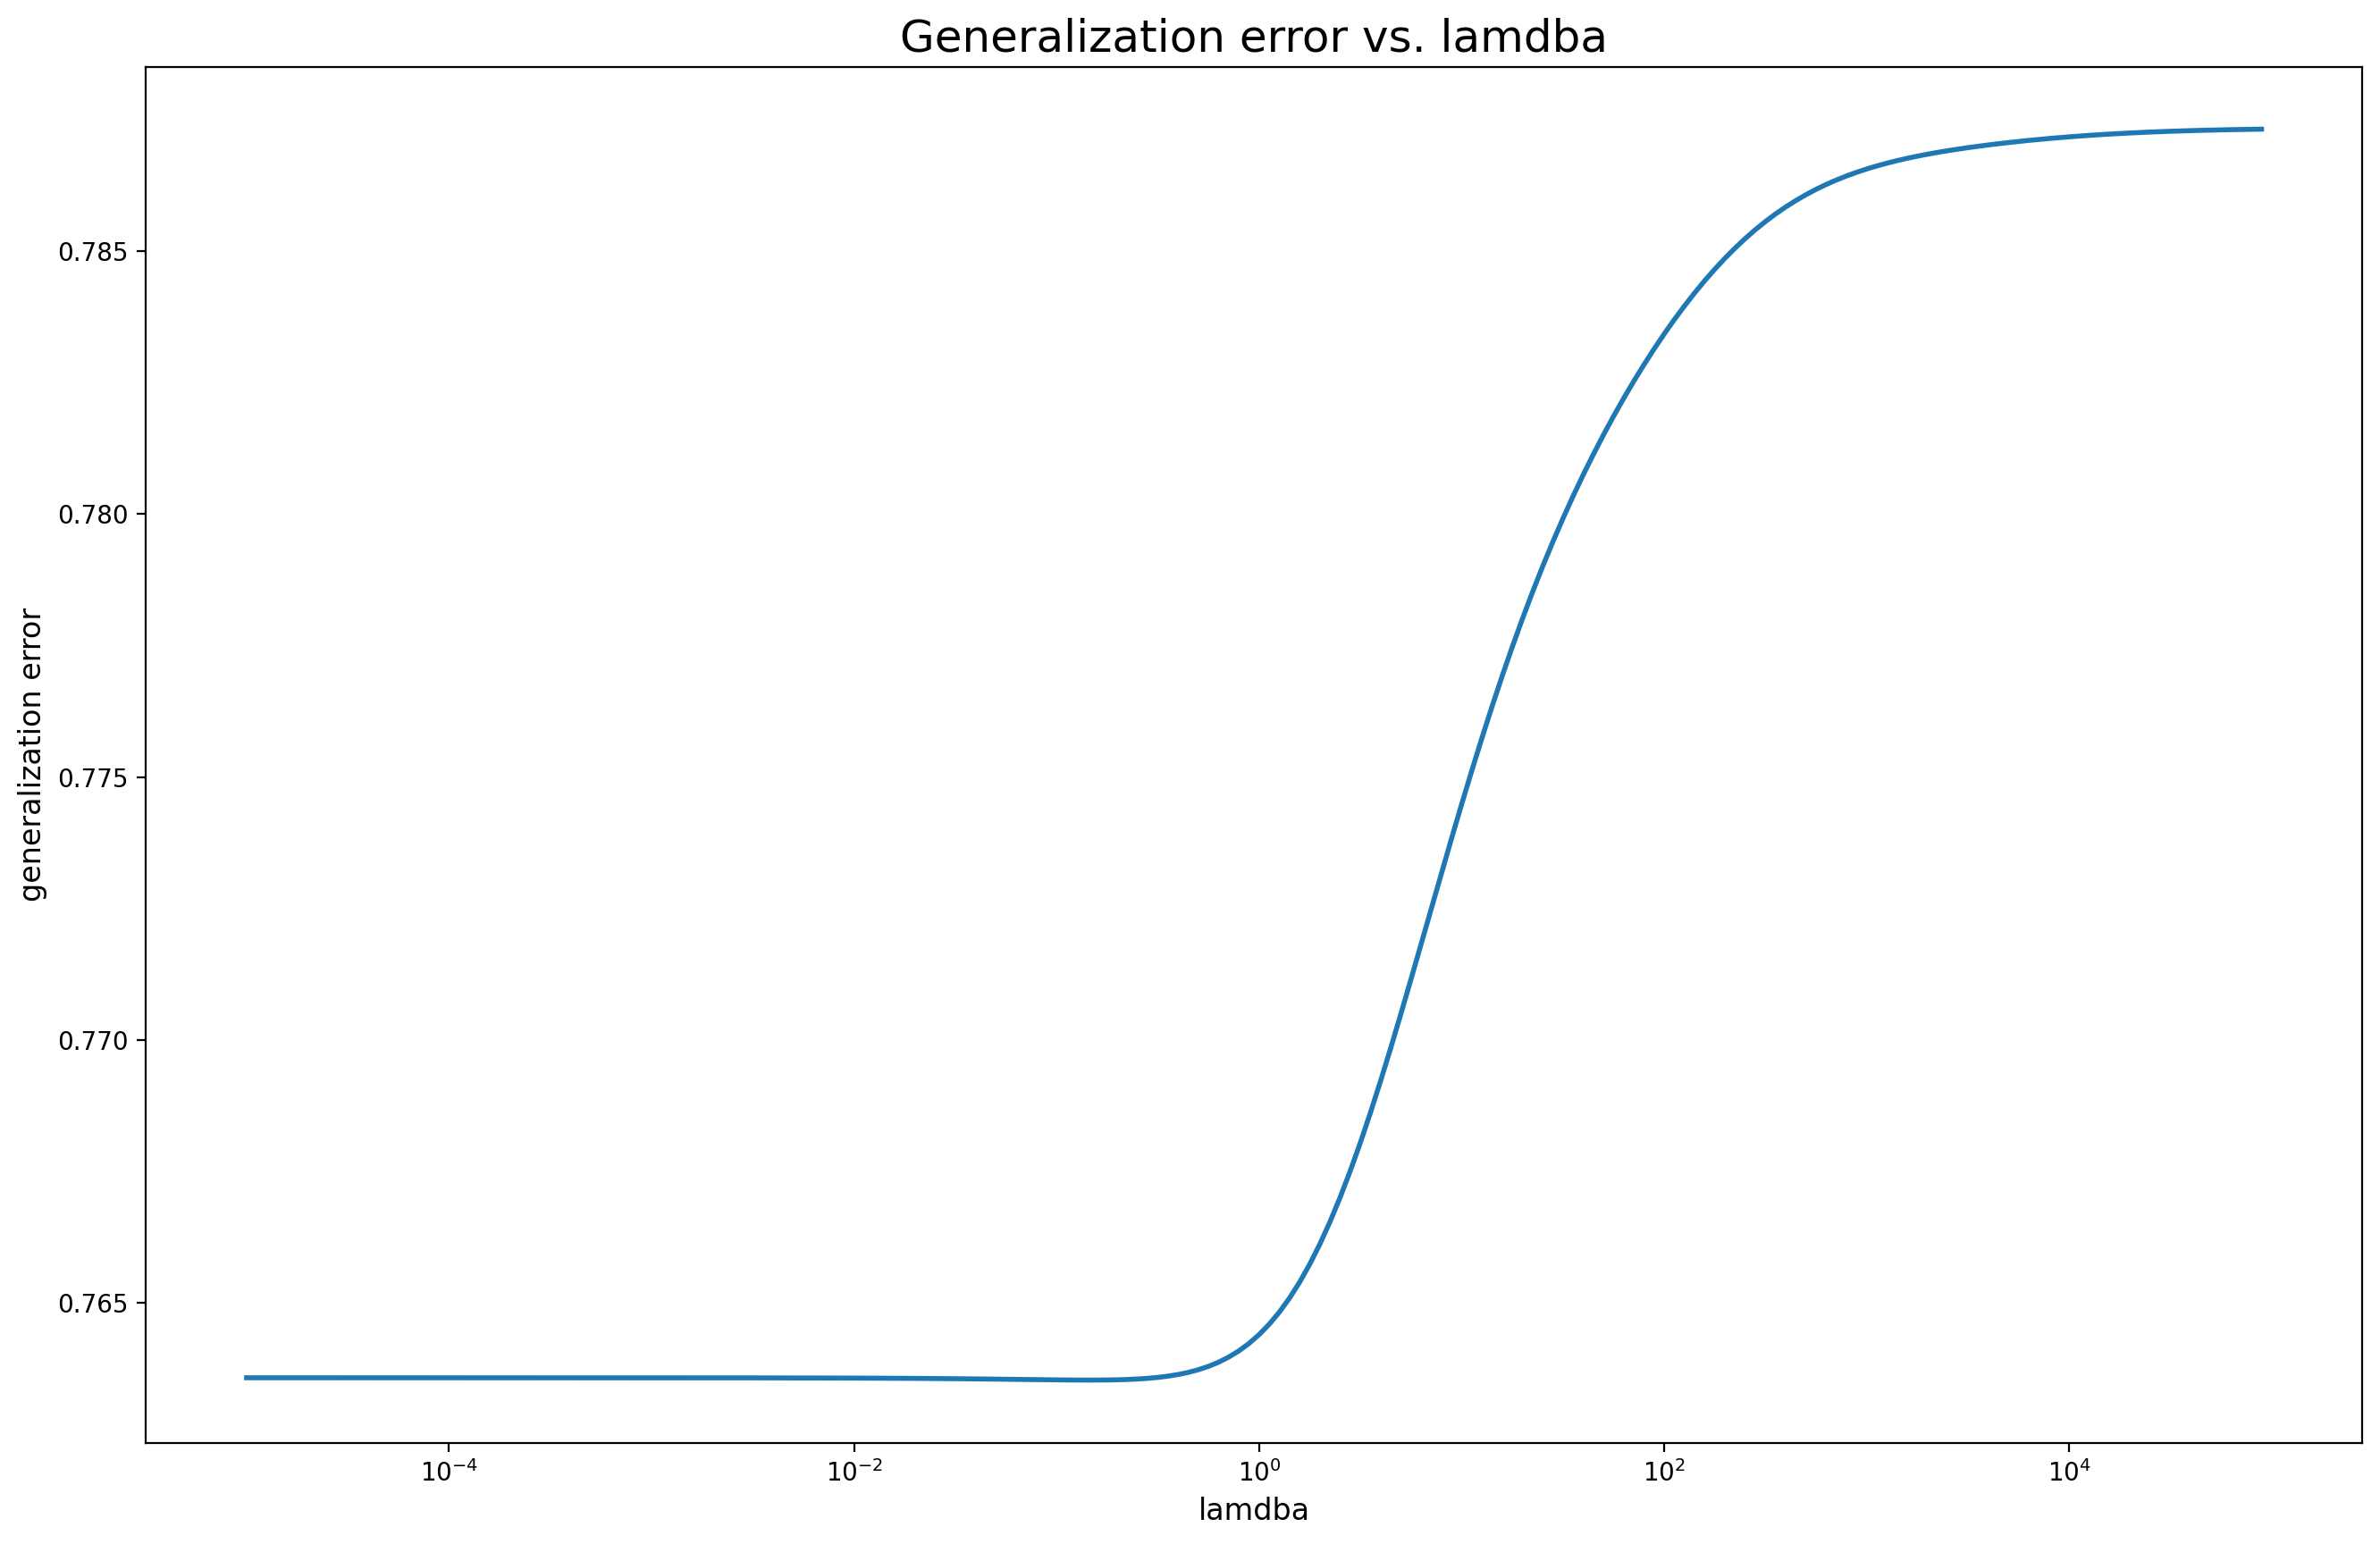

In [13]:
# plot figures
fig_1a, ax_1a = plt.subplots(figsize=(16,10))
ax_1a.semilogx(lambdas_1a, test_err_vs_lambda , linestyle= '-',linewidth=2,label='o')
ax_1a.set_xlabel('lamdba',fontsize=12)
ax_1a.set_ylabel('generalization error',fontsize=12)
ax_1a.set_title('Generalization error vs. lamdba',fontsize=18)
# save the figure
save_path_1a = "../project2_fig/1a.png"
fig_1a.savefig(save_path_1a, dpi=300)

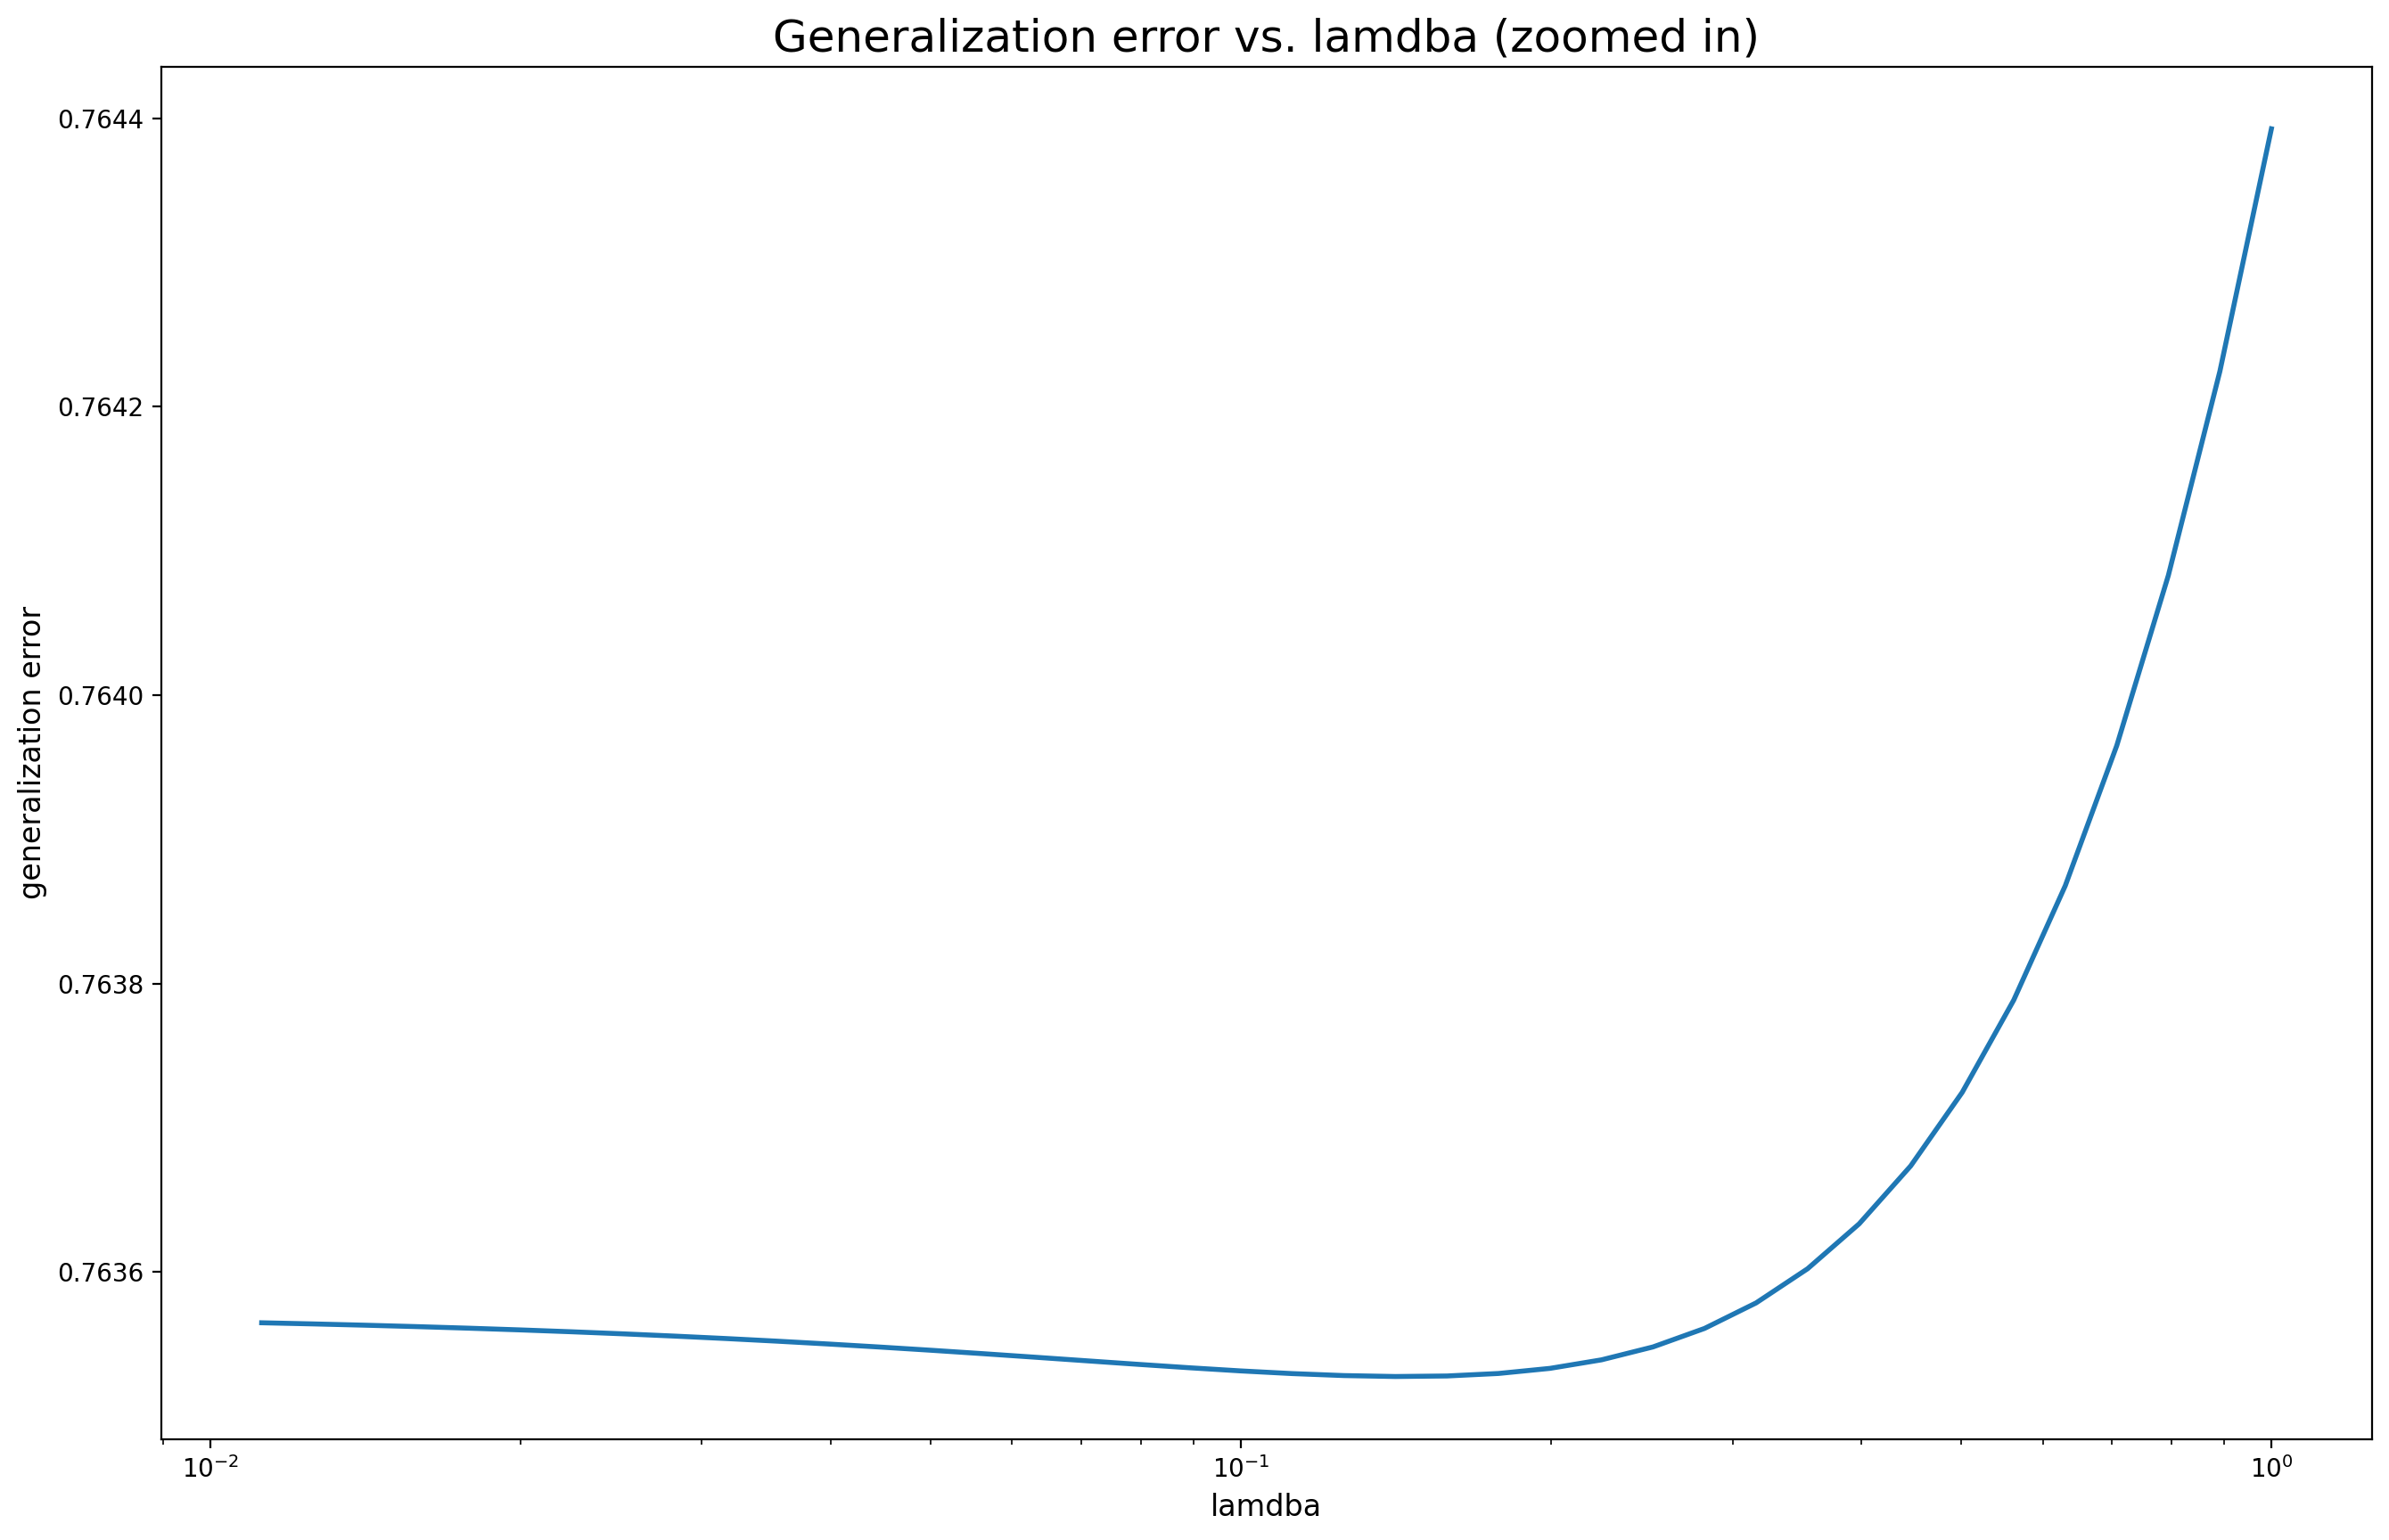

In [14]:
# plot a detailed figure near the minimum
fig_1a_zoom, ax_1a_zoom = plt.subplots(figsize=(16,10))
pick_zoom = (0.01<lambdas_1a) & (lambdas_1a<1)
lambdas_1a_zoom = lambdas_1a[pick_zoom]
test_err_vs_lambda_zoom = test_err_vs_lambda[pick_zoom]
ax_1a_zoom.semilogx(lambdas_1a_zoom, test_err_vs_lambda_zoom , linestyle= '-',linewidth=2,label='o')
ax_1a_zoom.set_xlabel('lamdba',fontsize=12)
ax_1a_zoom.set_ylabel('generalization error',fontsize=12)
ax_1a_zoom.set_title('Generalization error vs. lamdba (zoomed in)',fontsize=18)
# save the figure
save_path_1a_zoom = "../project2_fig/1a.png"
fig_1a.savefig(save_path_1a_zoom, dpi=300)

In [15]:
# get the optimal lambda and the corresponding error
arg_opt = np.argmin(test_err_vs_lambda)
opt_lambda = lambdas_1a[arg_opt]
err_opt = test_err_vs_lambda[arg_opt]
print('optimal lambda:',opt_lambda)
print('corresponding error:',err_opt)

optimal lambda: 0.14125375446227065
corresponding error: 0.7635275283770351


optimal weight: [ 0.13905423  0.04139021 -0.04920625 -0.05223453 -0.08665748  0.00039409
  0.00028821]


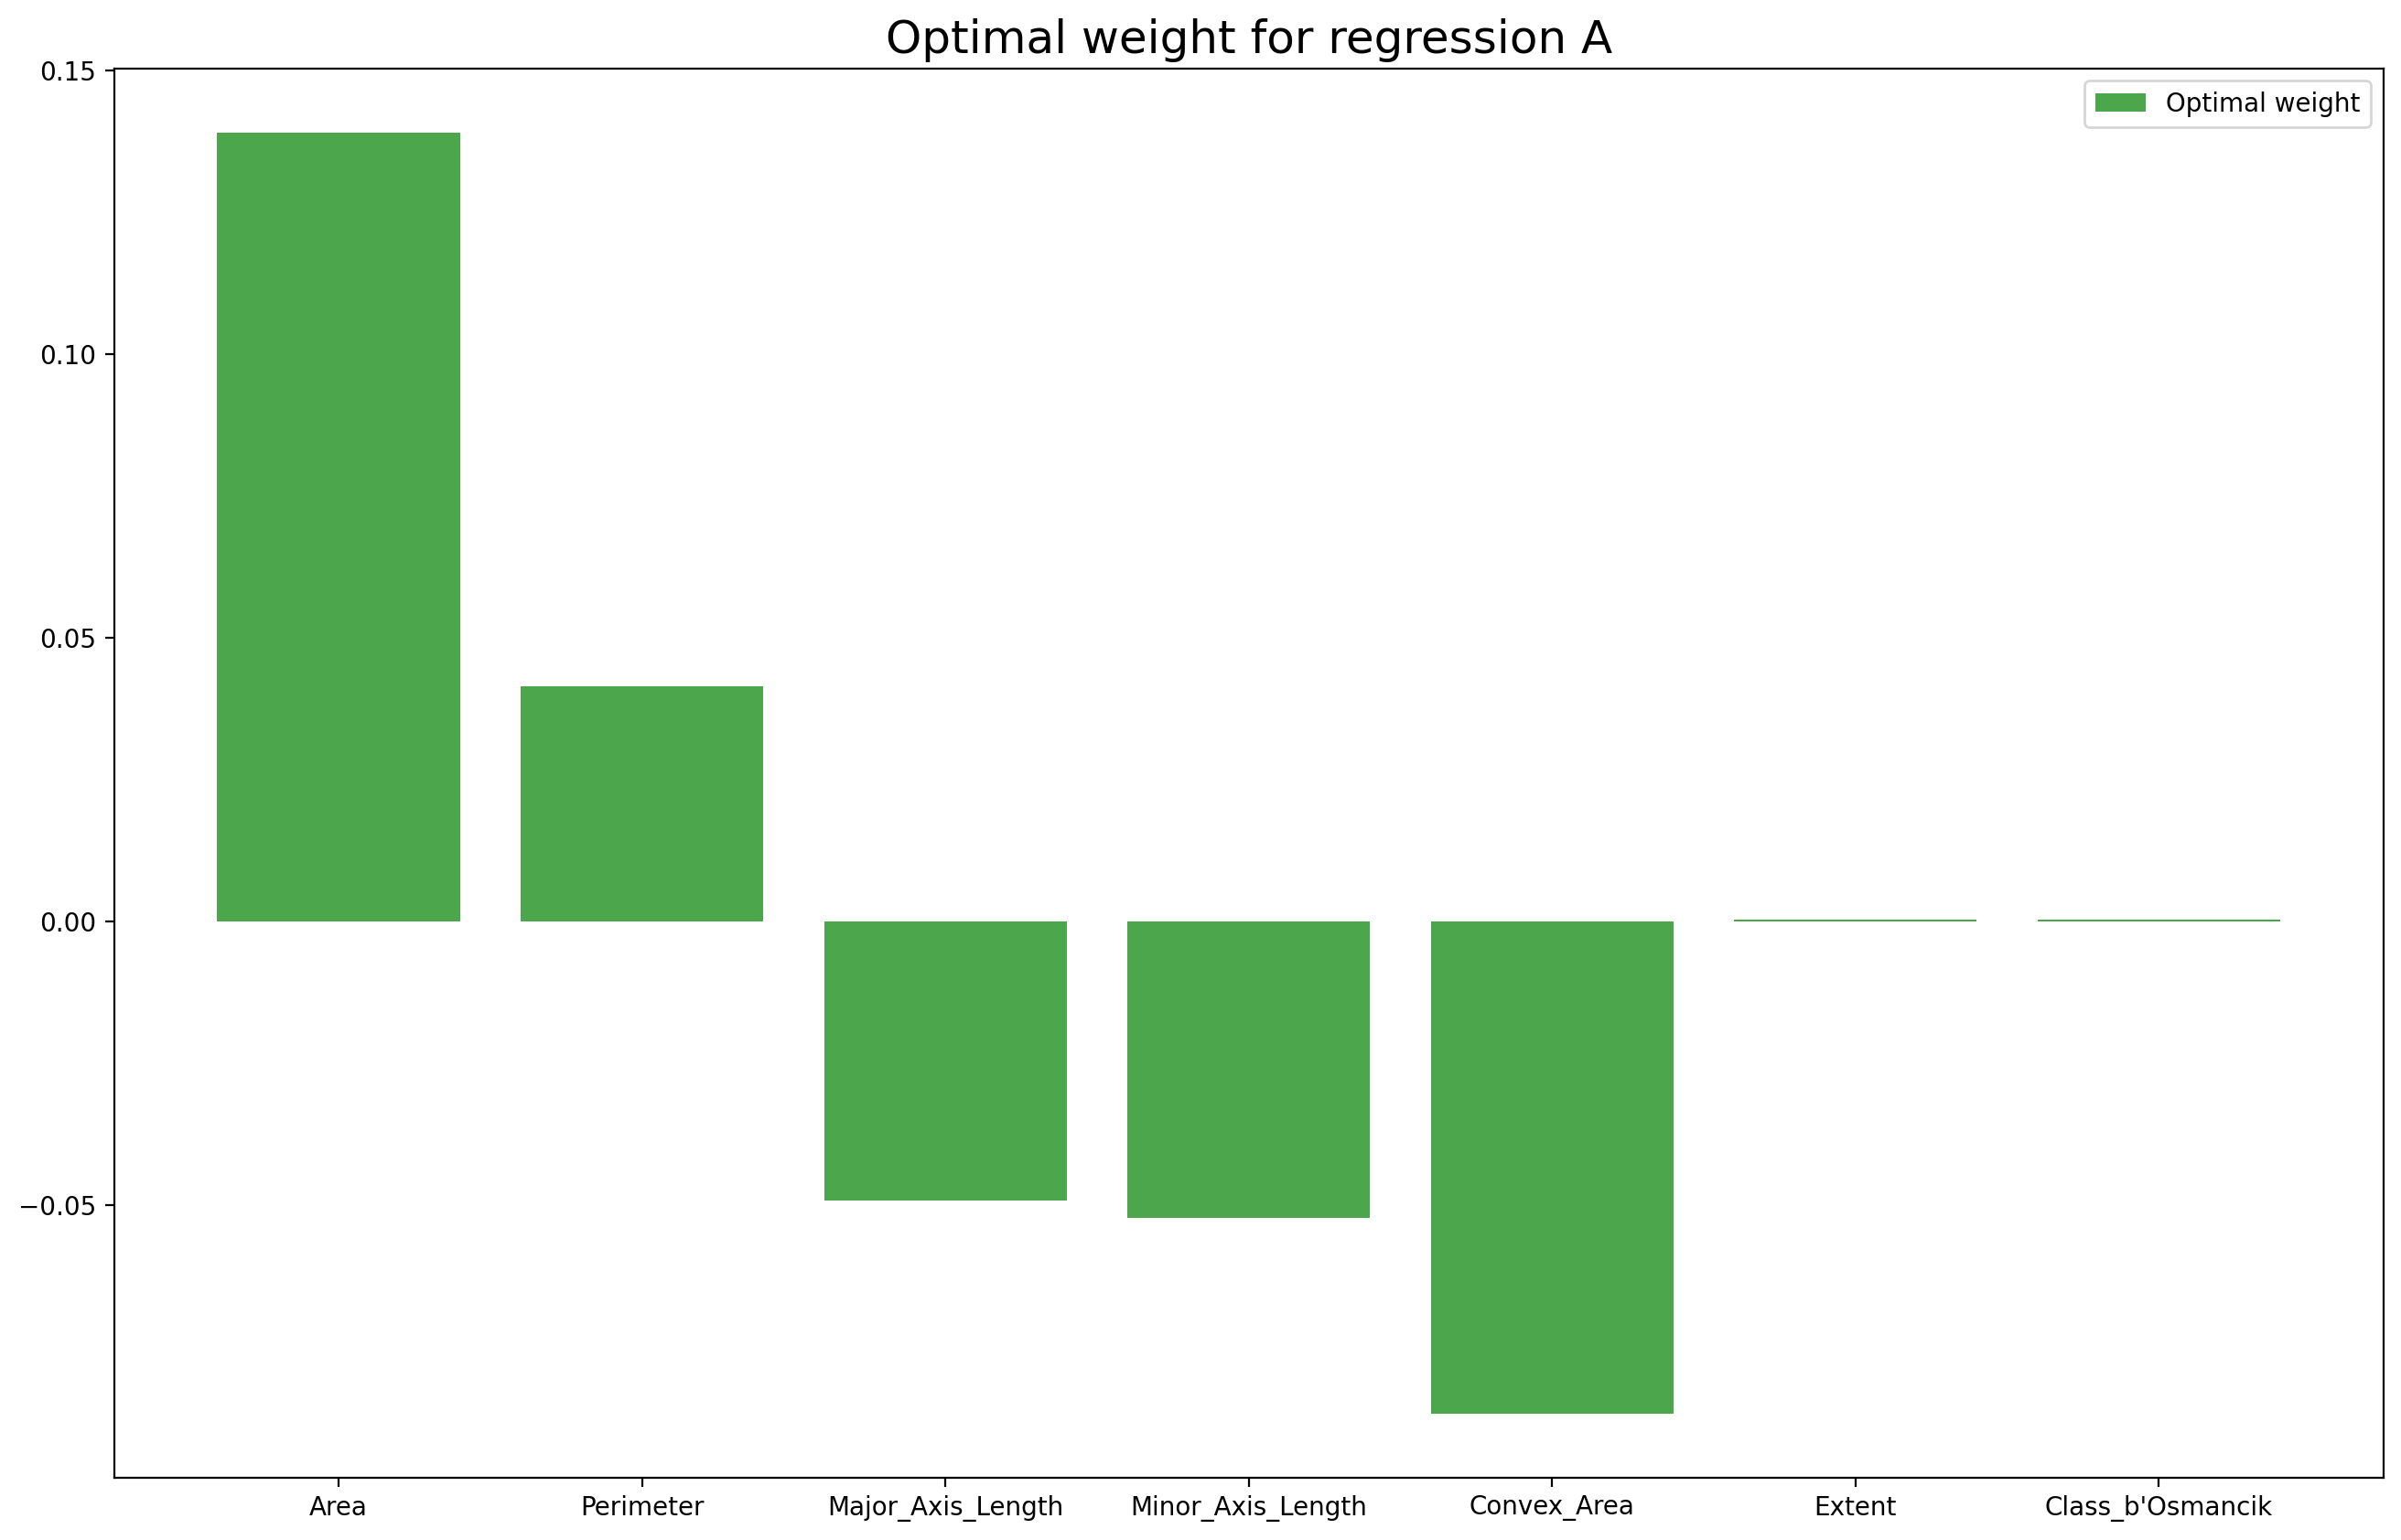

In [16]:
# 解决第二问问题后，还需根据最优lambda值，计算最优权重，进而回答第三问中是否make sense的问题
# compute the optimal weight
# get the optimal weight
opt_w = mean_w_vs_lambda[:,arg_opt]
print('optimal weight:',opt_w)
# plot the weight for each feature and set the horizontal axis as the feature names
fig_1a_w, ax_1a_w = plt.subplots(figsize=(16,10))
ax_1a_w.bar(X.columns, opt_w, color='g', alpha=0.7, label='Optimal weight')
ax_1a_w.set_title('Optimal weight for regression A',fontsize=18)
ax_1a_w.legend()
# save the figure
save_path_1a_w = "../project2_fig/1a_w.png"
fig_1a_w.savefig(save_path_1a_w, dpi=300)

### The output y of the linear model with the lowest generalization error is computed as follows:
y = Xw
where X is the input data matrix, and w is the weight vector. The weight vector w is determined by the regularized least squares method, which minimizes the sum of squared errors between the predicted output and the true output. The effect of an individual attribute in x on the output y of the linear model is determined by the corresponding weight in the weight vector w. The weight vector w is a linear combination of the input attributes, and the weight of each attribute determines the contribution of that attribute to the output y. 
As can be seen from the optimal weight plot, some features including "area" and "perimeter"
have a significant positive impact on the eccentricity, while some features like "major_axis_length" and "convex_area"
have a significant negative impact on the eccentricity. 
The behavior of feature 'area' makes sense because the eccentricity
is a measure of how much an ellipse deviates from a circle, and given its perimeter and other features,
the less the ellipse deviates from a circle (i.e., the larger its eccentricity or the closer its eccentricity to 1),
the larger the area should be. 
However, the behavior of feature 'periemter' is not intuitive, because theoretically, the perimeter of an ellipse
should have a negative impact on the eccentricity. But if we consider the fact that the absolute value of the weight
of 'perimeter' is much smaller than that of 'area', we can conclude that the weight of 'perimeter' is not significant.
The behavior of feature 'minor_axis_length' also makes sense because the eccentricity is defined as the ratio of the
distance between the foci of an ellipse to its major axis length, so the larger the minor axis length, the smaller the eccentricity.
As for other features, their weights' absolute values are small, so they are not so significant.

# Regression Part B

Two-level cross-validation

Cross validation fold 1/10
Train indices: [   0    1    2 ... 3807 3808 3809]
Test indices: [  13   41   56   70   76   85   86  102  112  116  147  152  165  169
  186  219  221  222  224  240  263  267  274  283  289  304  306  323
  334  350  358  373  377  385  393  397  403  404  431  441  443  458
  459  462  463  464  480  483  490  498  500  505  506  508  509  510
  527  534  547  570  587  620  637  651  652  660  667  679  685  690
  694  696  708  731  733  740  747  753  759  768  773  788  805  812
  822  829  836  838  847  886  887  896  899  936  939  955  974  975
  991  997 1004 1007 1027 1033 1035 1038 1046 1050 1054 1056 1070 1082
 1086 1089 1092 1098 1108 1112 1122 1155 1170 1175 1176 1182 1186 1192
 1201 1213 1216 1218 1222 1246 1250 1260 1266 1276 1280 1296 1317 1324
 1336 1358 1364 1392 1416 1425 1454 1480 1505 1522 1524 1532 1544 1549
 1556 1564 1567 1571 1586 1590 1599 1604 1607 1613 1614 1618 1622 1668
 1673 1696 1720 1740 1747 1753 1776 1781 1793 1801 1802 

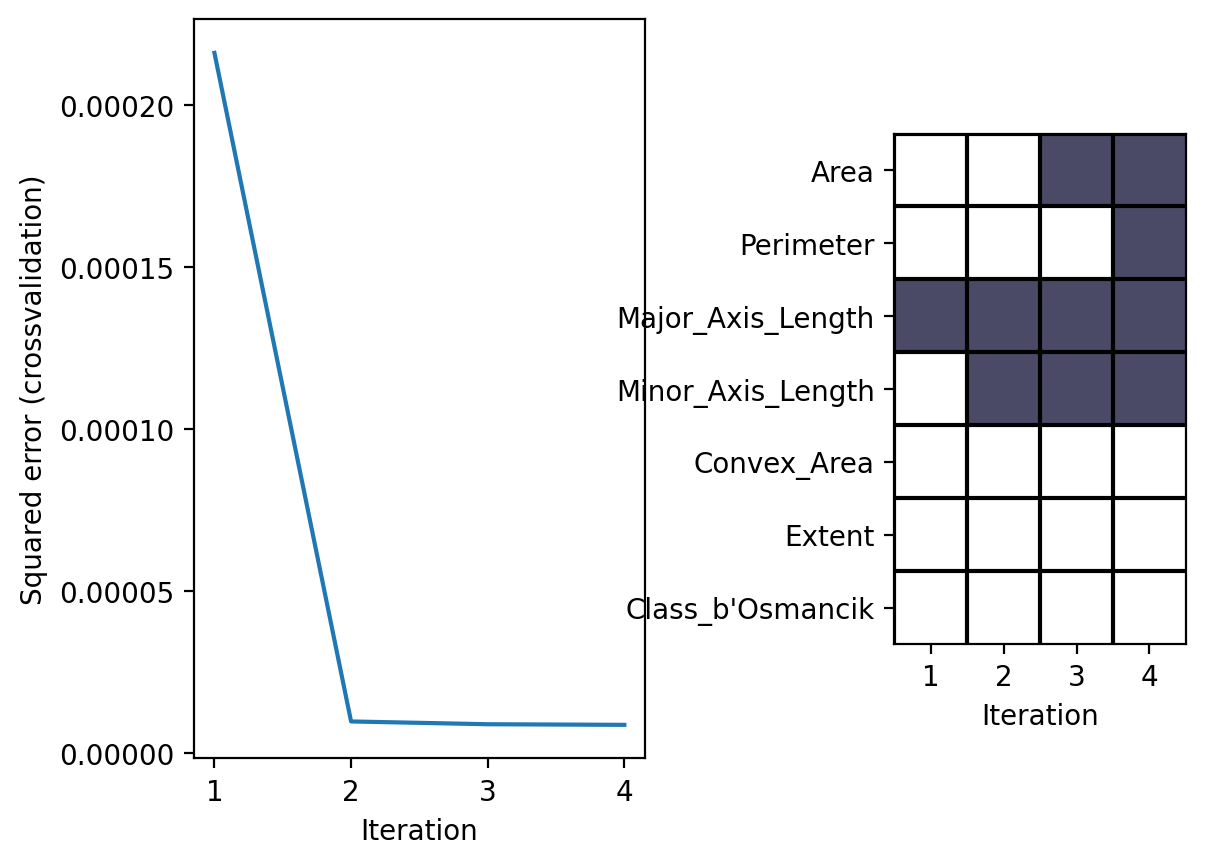

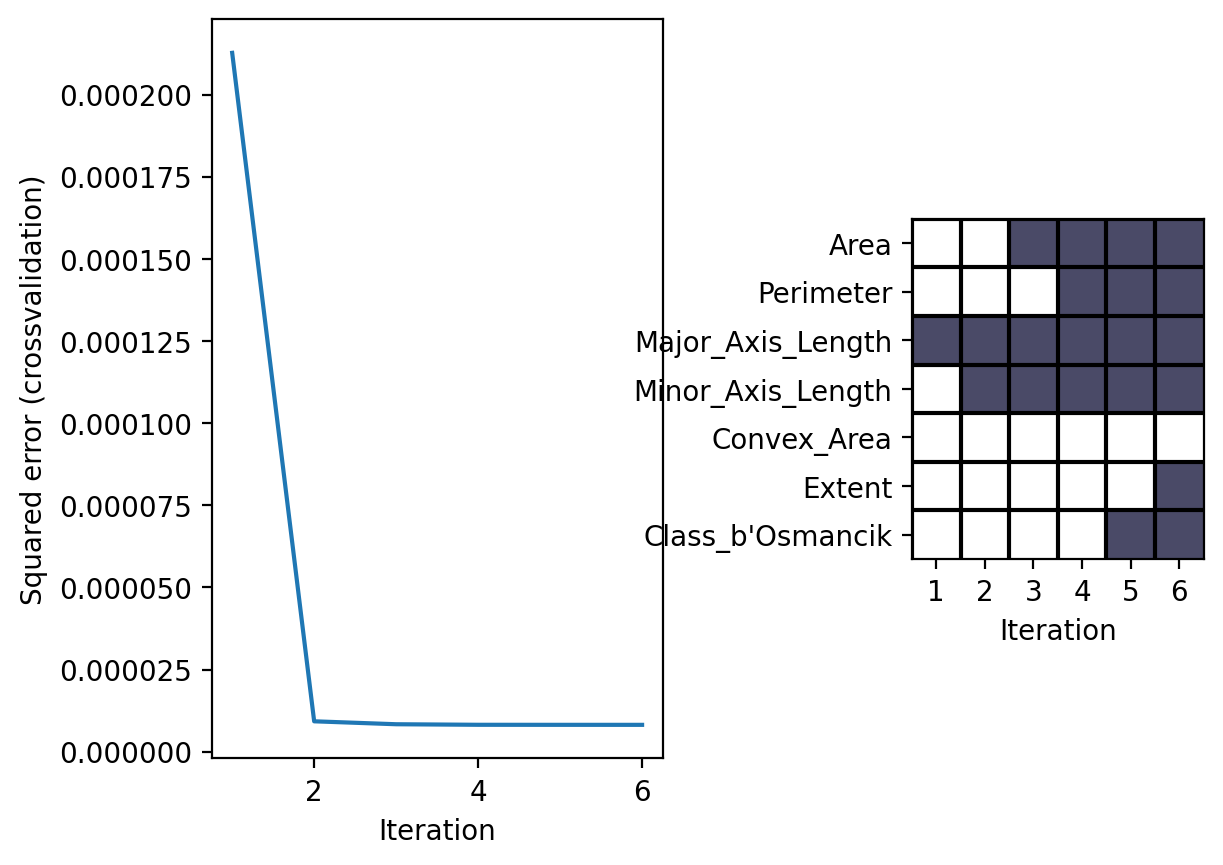

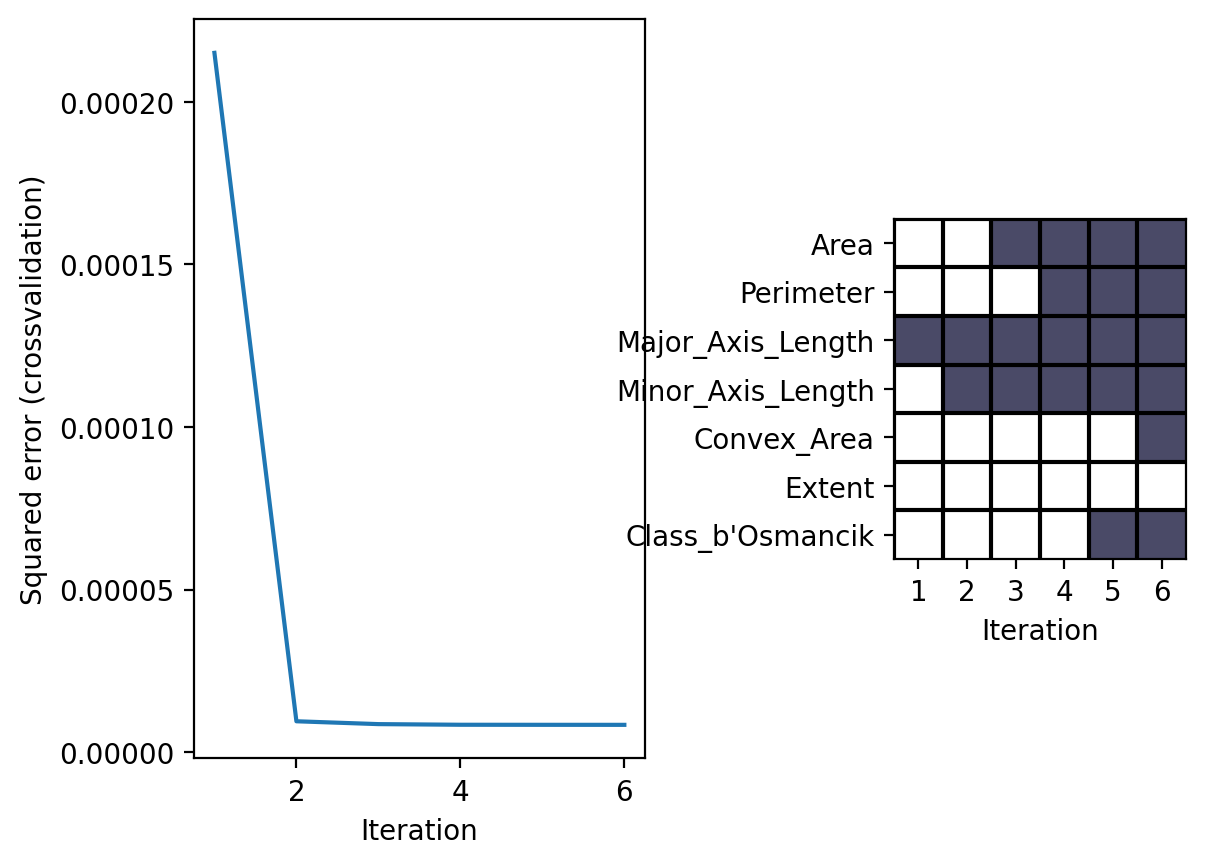

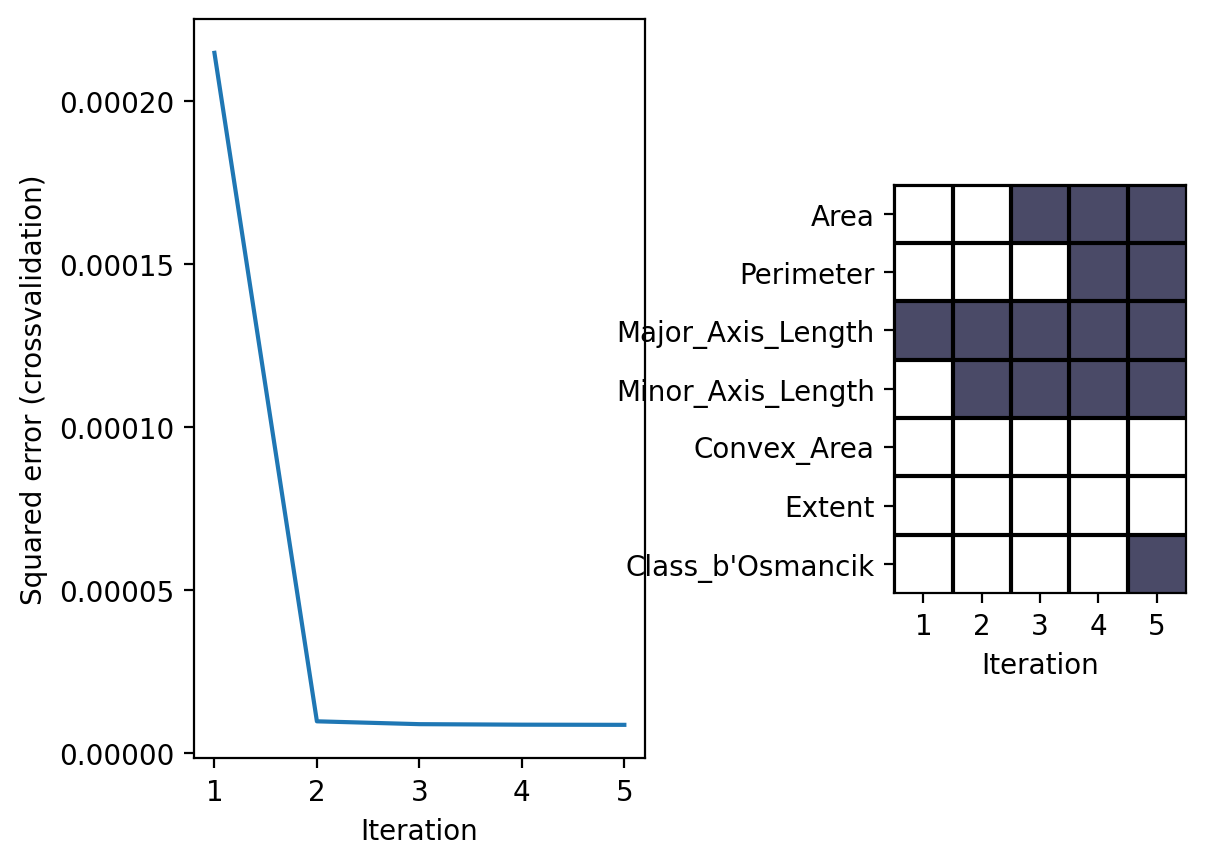

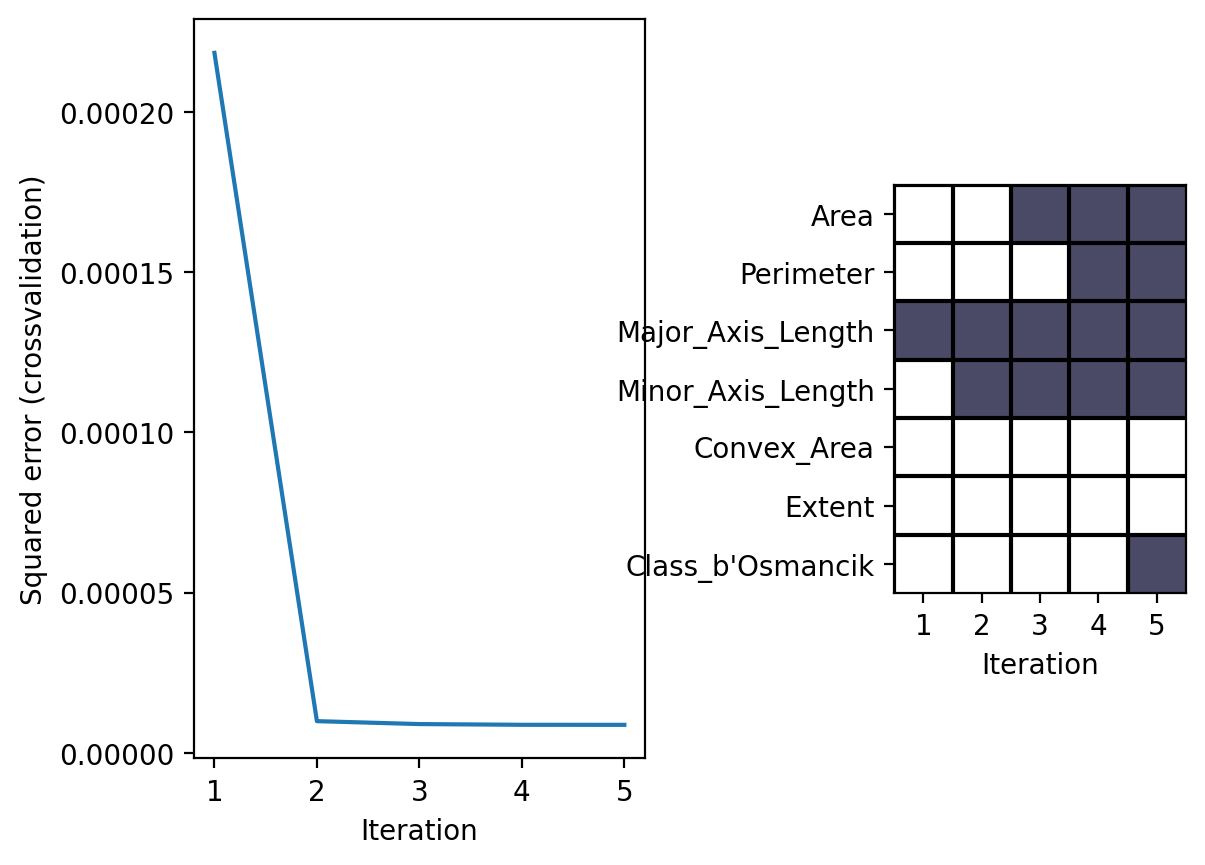

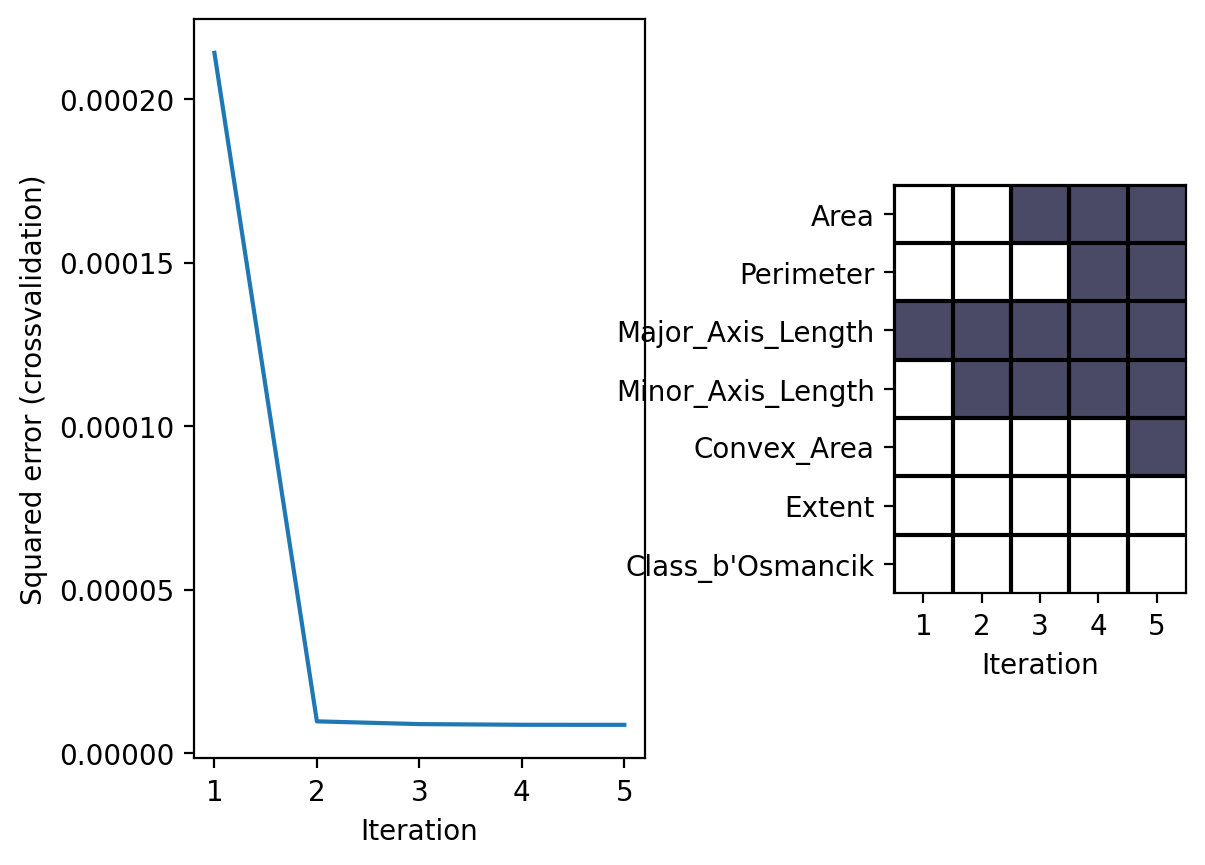

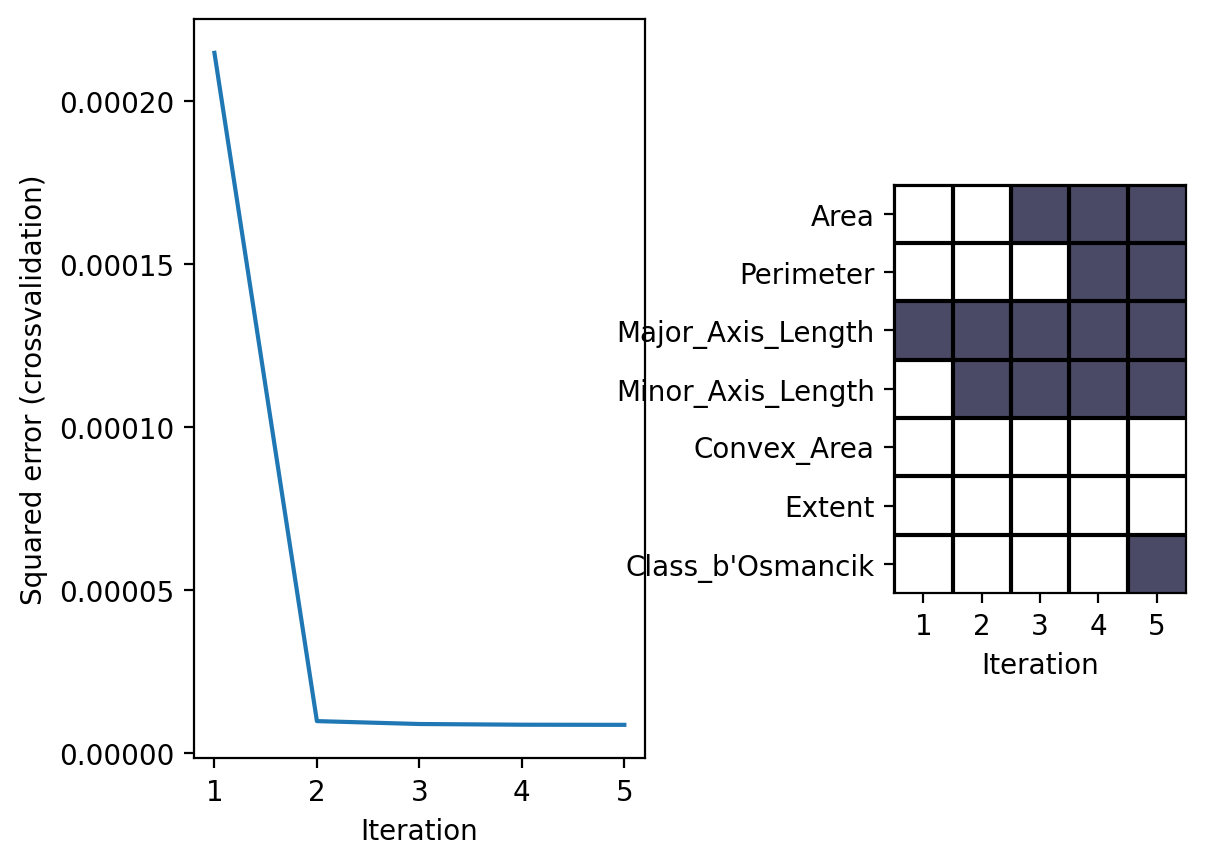

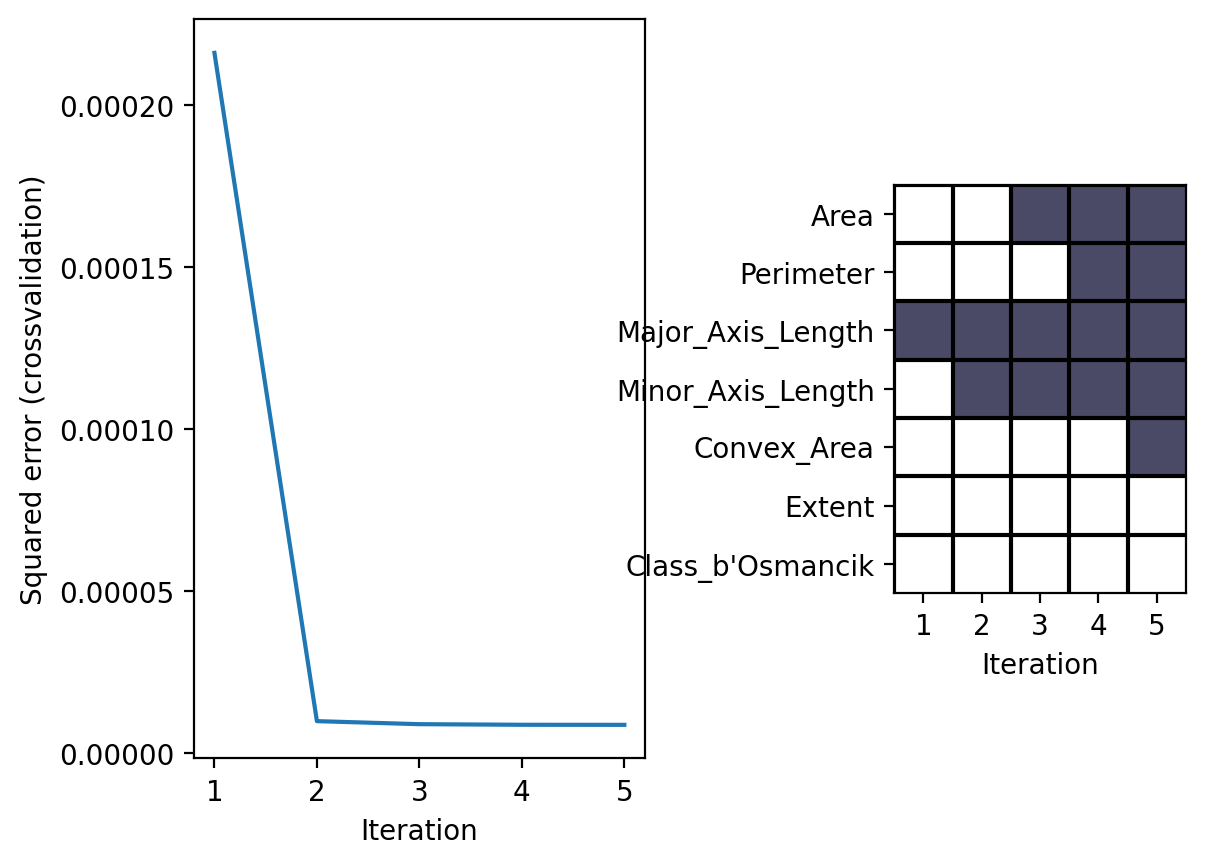

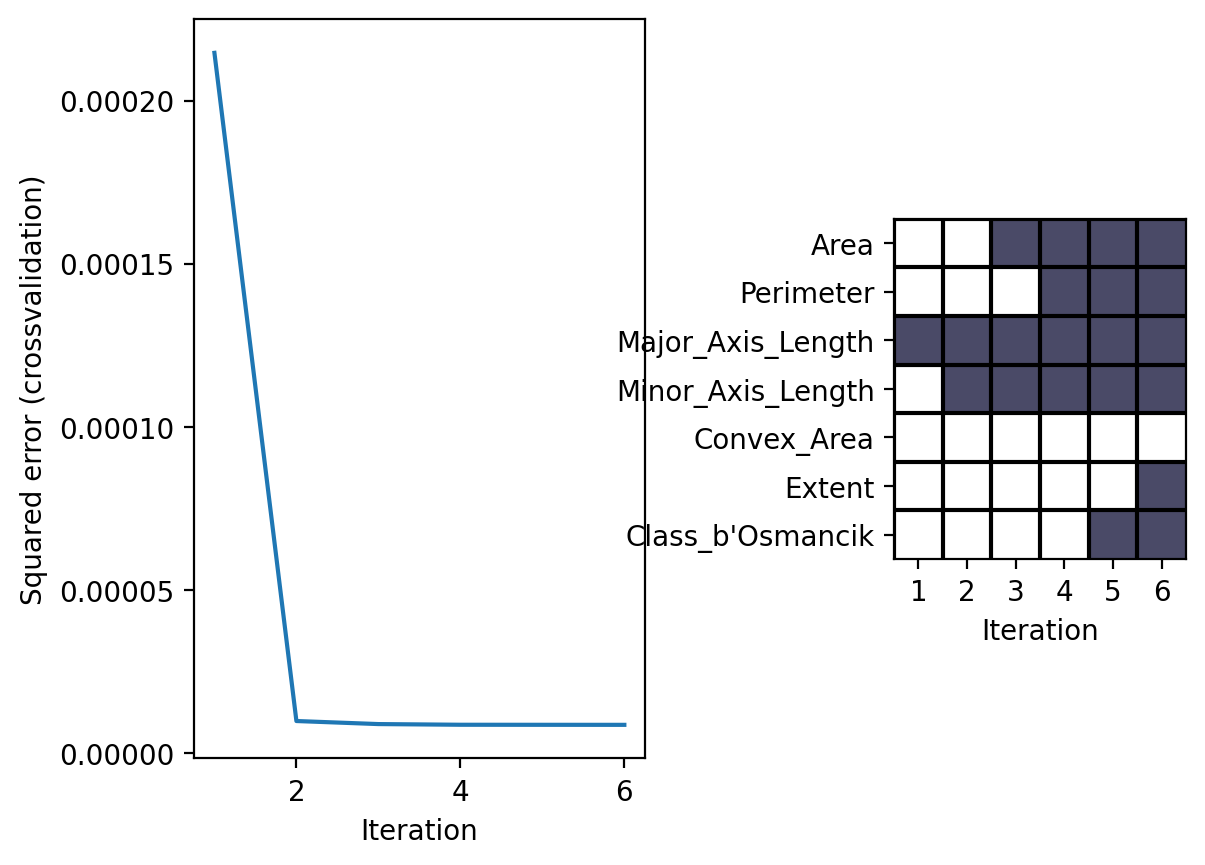

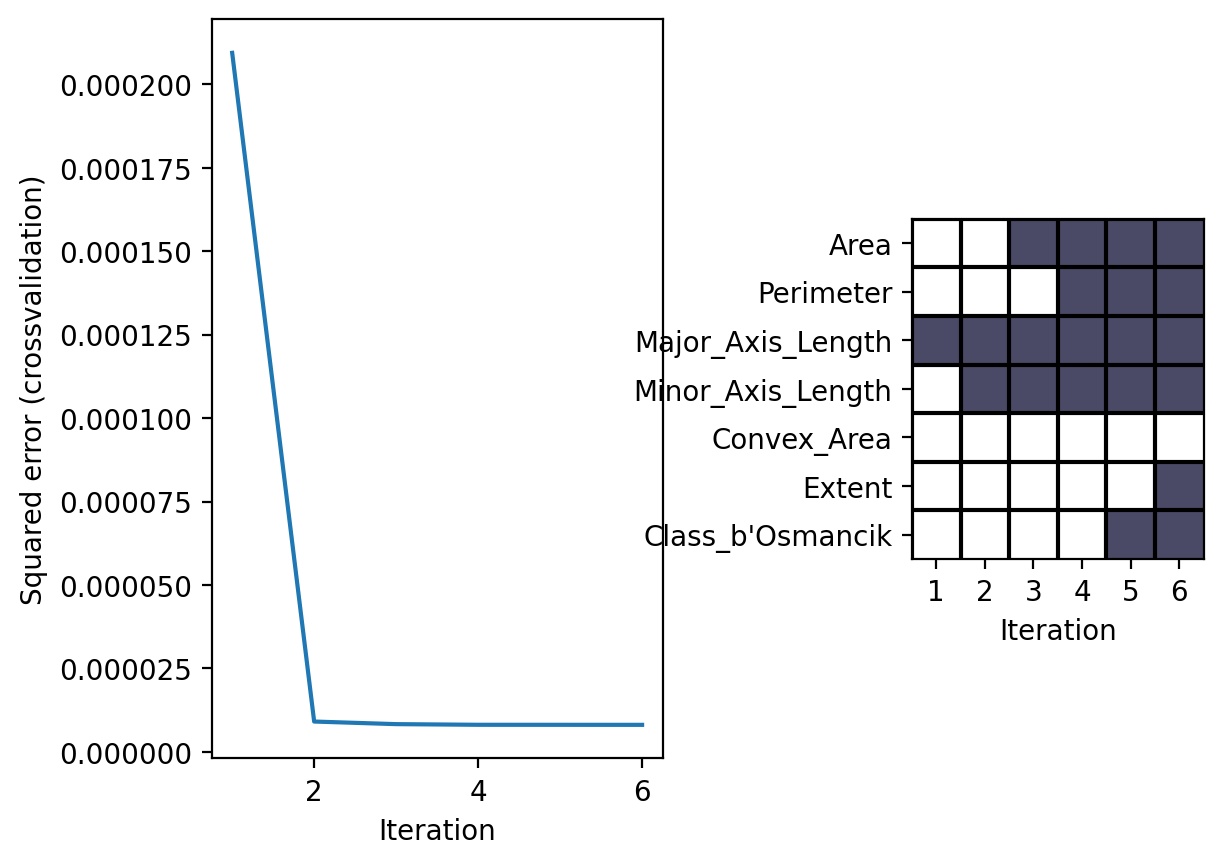

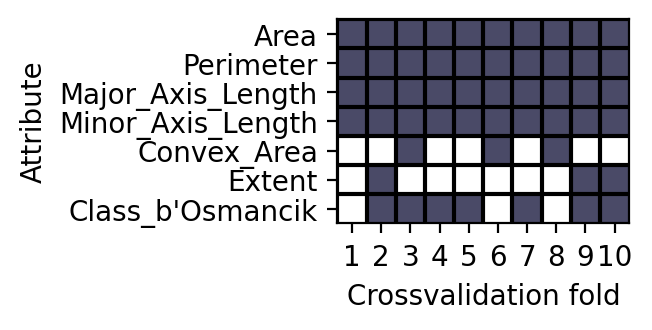

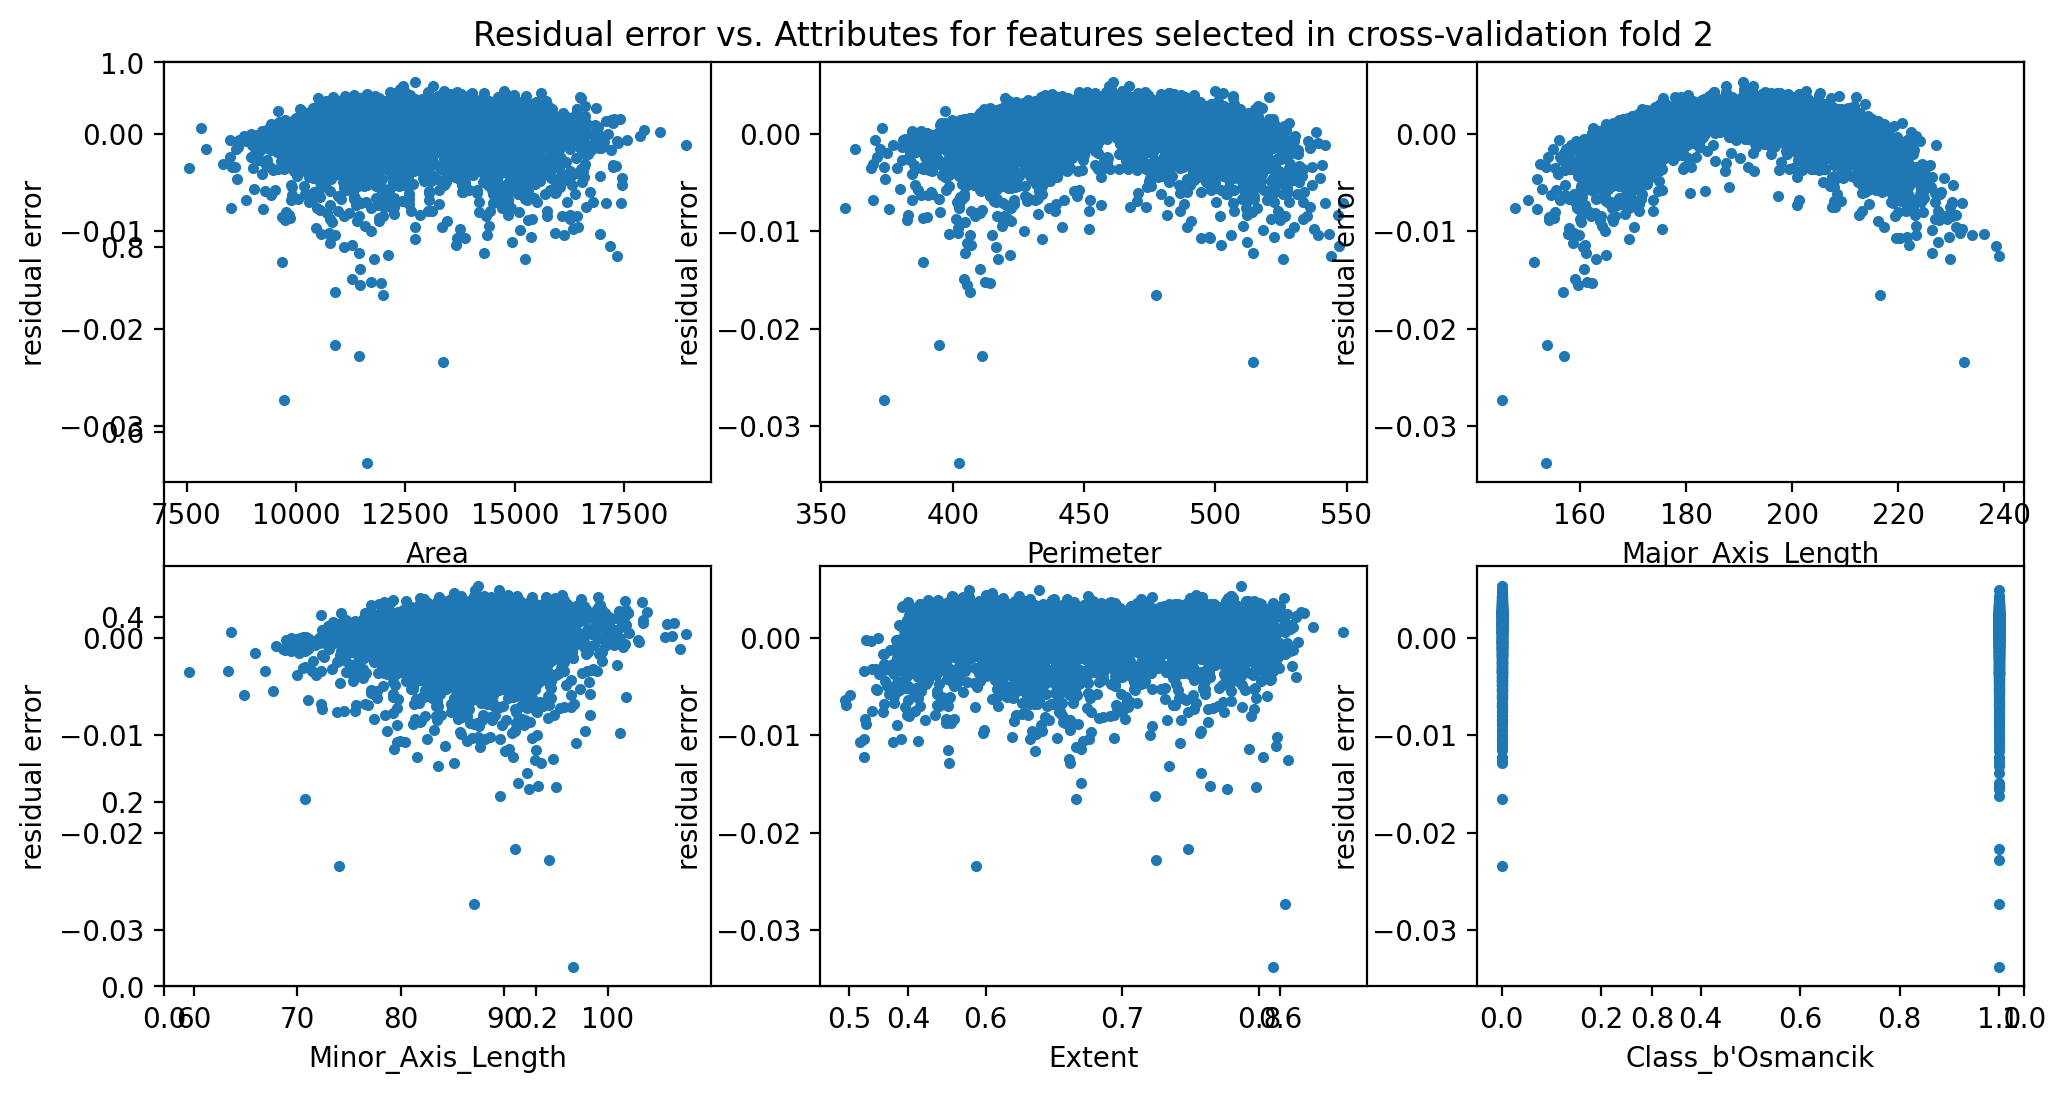

In [17]:

data = pd.read_csv(data_file)

data = pd.get_dummies(data, columns=["Class"], drop_first=True)
# transform True/False to 1/0 (categorical feature "Class_b'Osmancik")
data["Class_b'Osmancik"] = data["Class_b'Osmancik'"].astype(int)
data = data.drop(columns=["Class_b'Osmancik'"])
X = data.drop(columns=["Eccentricity"])
attributeNames = X.columns.tolist()
X=X.values
y = data["Eccentricity"]
y=y.values


N, M = X.shape

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV.split(X):
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    textout = ''
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k] = 1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) == 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')

    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Train indices: {0}'.format(train_index))
    print('Test indices: {0}'.format(test_index))
    print('Features no: {0}\n'.format(selected_features.size))

    k+=1


# Display results
print('\n')
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))

figure(k)
subplot(1,3,2)
bmplot(attributeNames, range(1,Features.shape[1]+1), -Features)
clim(-1.5,0)
xlabel('Crossvalidation fold')
ylabel('Attribute')


# Inspect selected feature coefficients effect on the entire dataset and
# plot the fitted model residual error as function of each attribute to
# inspect for systematic structure in the residual

f=2 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
if len(ff) == 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X[:,ff], y)
    
    y_est= m.predict(X[:,ff])
    residual=y-y_est
    
    figure(k+1, figsize=(12,6))
    title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
    for i in range(0,len(ff)):
       subplot(2, int( np.ceil(len(ff)/2)), i+1)
       plot(X[:,ff[i]],residual,'.')
       xlabel(attributeNames[ff[i]])
       ylabel('residual error')
    
    
show()


Baseline model: linear regression model with no features

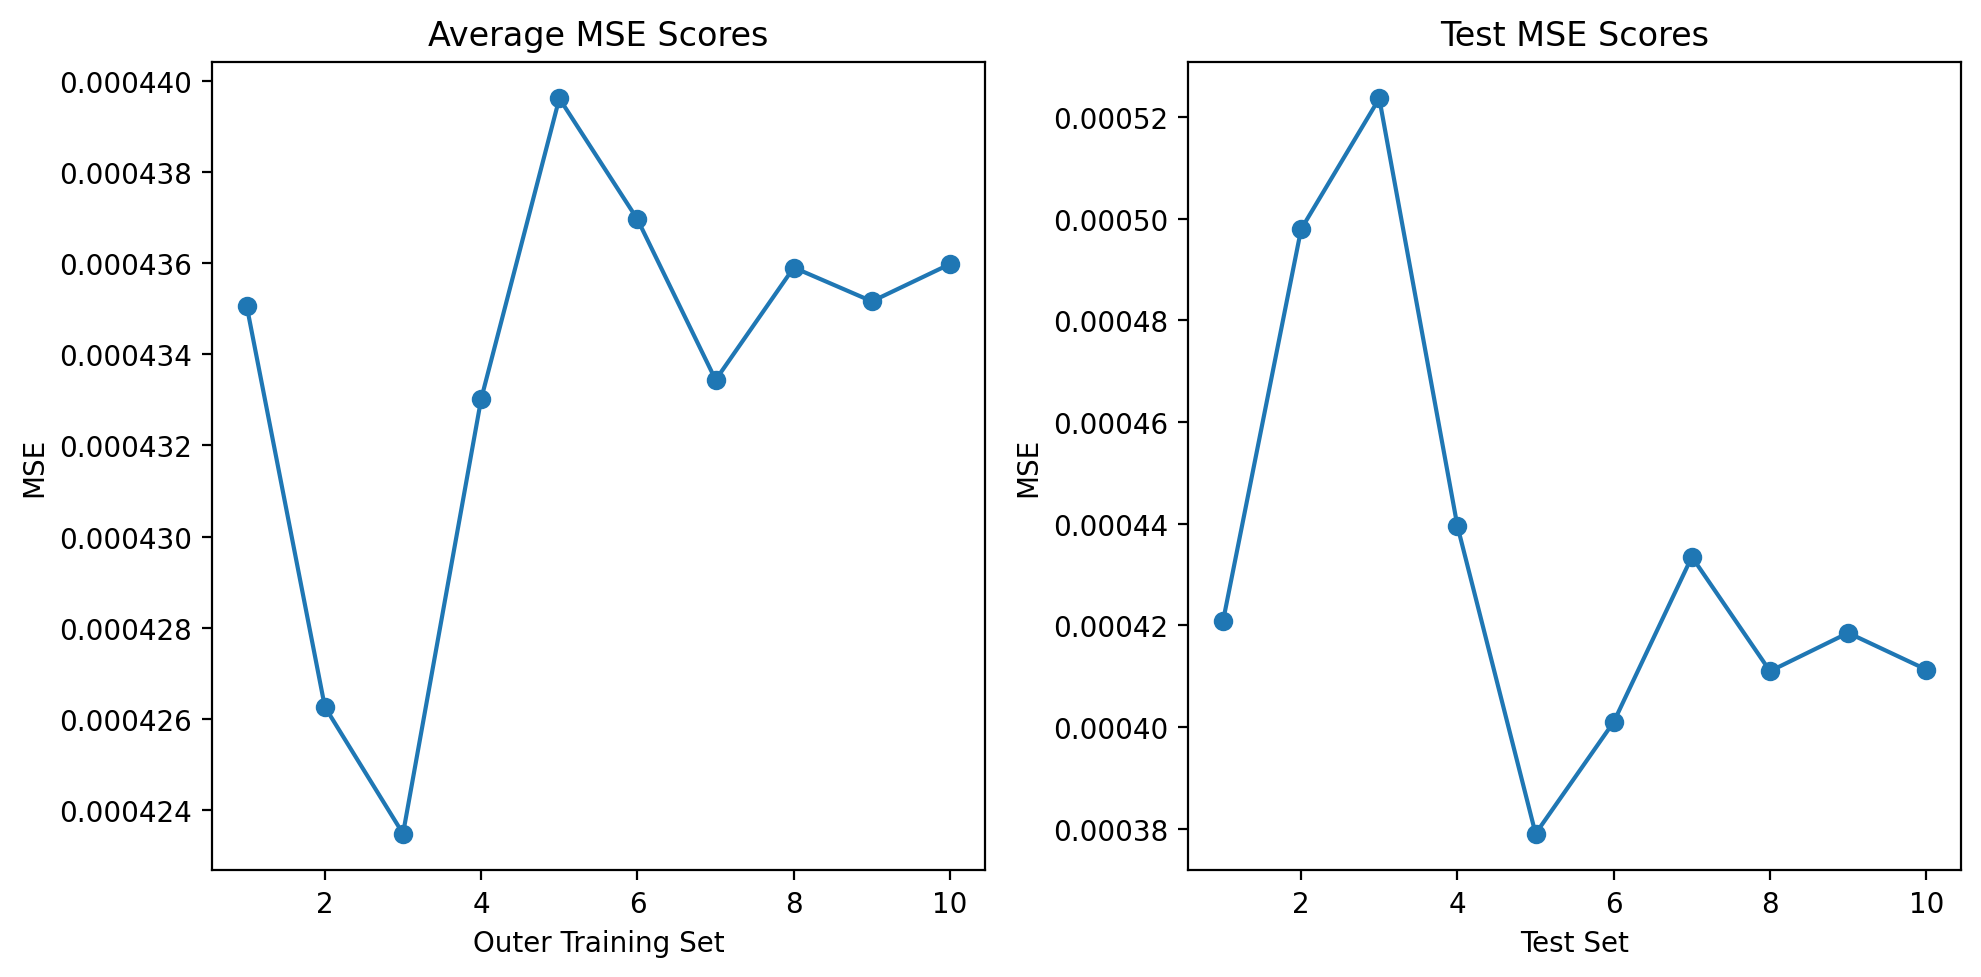

In [18]:

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def two_level_cv(X, y, K1=10, K2=10):
    # Level 1 Cross Validation
    kf1 = KFold(n_splits=K1, shuffle=True, random_state=1)
    
    model_performance = []
    
    for train_index, test_index in kf1.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Level 2 Cross Validation
        kf2 = KFold(n_splits=K2, shuffle=True, random_state=1)
        
        cv_scores = []
        
        for inner_train_index, inner_val_index in kf2.split(X_train):
            X_inner_train, X_inner_val = X_train[inner_train_index], X_train[inner_val_index]
            y_inner_train, y_inner_val = y_train[inner_train_index], y_train[inner_val_index]
            
            # Baseline Model: Mean of y
            baseline_pred = np.mean(y_inner_train)
            
            # Compute the MSE
            mse = mean_squared_error(y_inner_val, np.full(len(y_inner_val), baseline_pred))
            cv_scores.append(mse)

        # Average MSE score
        avg_mse_score = np.mean(cv_scores)
        
        # Fit the model on the whole outer training set and evaluate on the test set
        baseline_pred_test = np.mean(y_train)
        test_mse = mean_squared_error(y_test, np.full(len(y_test), baseline_pred_test))
        
        model_performance.append((avg_mse_score, test_mse))
    
    return model_performance


# Run two-level cross-validation
model_performance = two_level_cv(X, y)

# Extract average MSE scores and test MSE scores
avg_mse_scores, test_mse_scores = zip(*model_performance)

# Create a new figure
plt.figure(figsize=(10, 5))

# Plot average MSE scores
plt.subplot(1, 2, 1)
plt.plot(range(1, len(avg_mse_scores) + 1), avg_mse_scores, marker='o')
plt.title('Average MSE Scores')
plt.xlabel('Outer Training Set')
plt.ylabel('MSE')

# Plot test MSE scores
plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_mse_scores) + 1), test_mse_scores, marker='o')
plt.title('Test MSE Scores')
plt.xlabel('Test Set')
plt.ylabel('MSE')

# Display the figure
plt.tight_layout()
plt.show()


ANN Model

Training model of type:

Sequential(
  (0): Linear(in_features=7, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)


Crossvalidation fold: 1/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.0001409055	0.00222833
		2000	4.2509277e-05	0.0007832208
		3000	1.9241763e-05	0.00083356193
		4000	8.378043e-06	0.0007753633
		5000	4.537444e-06	0.00042746036
		6000	3.4277175e-06	0.0001733003
		7000	2.9881783e-06	0.00012697987
		8000	2.5678332e-06	0.0001890119
		9000	1.9881693e-06	0.00033645806
		10000	1.2440381e-06	0.00057183637
		Final loss:
		10000	1.2440381e-06	0.00057183637

	Best loss: 1.2440381169653847e-06


Crossvalidation fold: 2/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.00037126543	0.0006570325
		2000	0.00025572244	0.0002412195
		3000	0.00021929458	0.000106360305
		4000	0.00019594801	0.00012905446
		5000	0.00016725402	0.00019667934
		6000	0.0001260095	0.00042329574
		7000	5.590212e-05	0.0014086361
		8000	5.15462e-06	0.013457

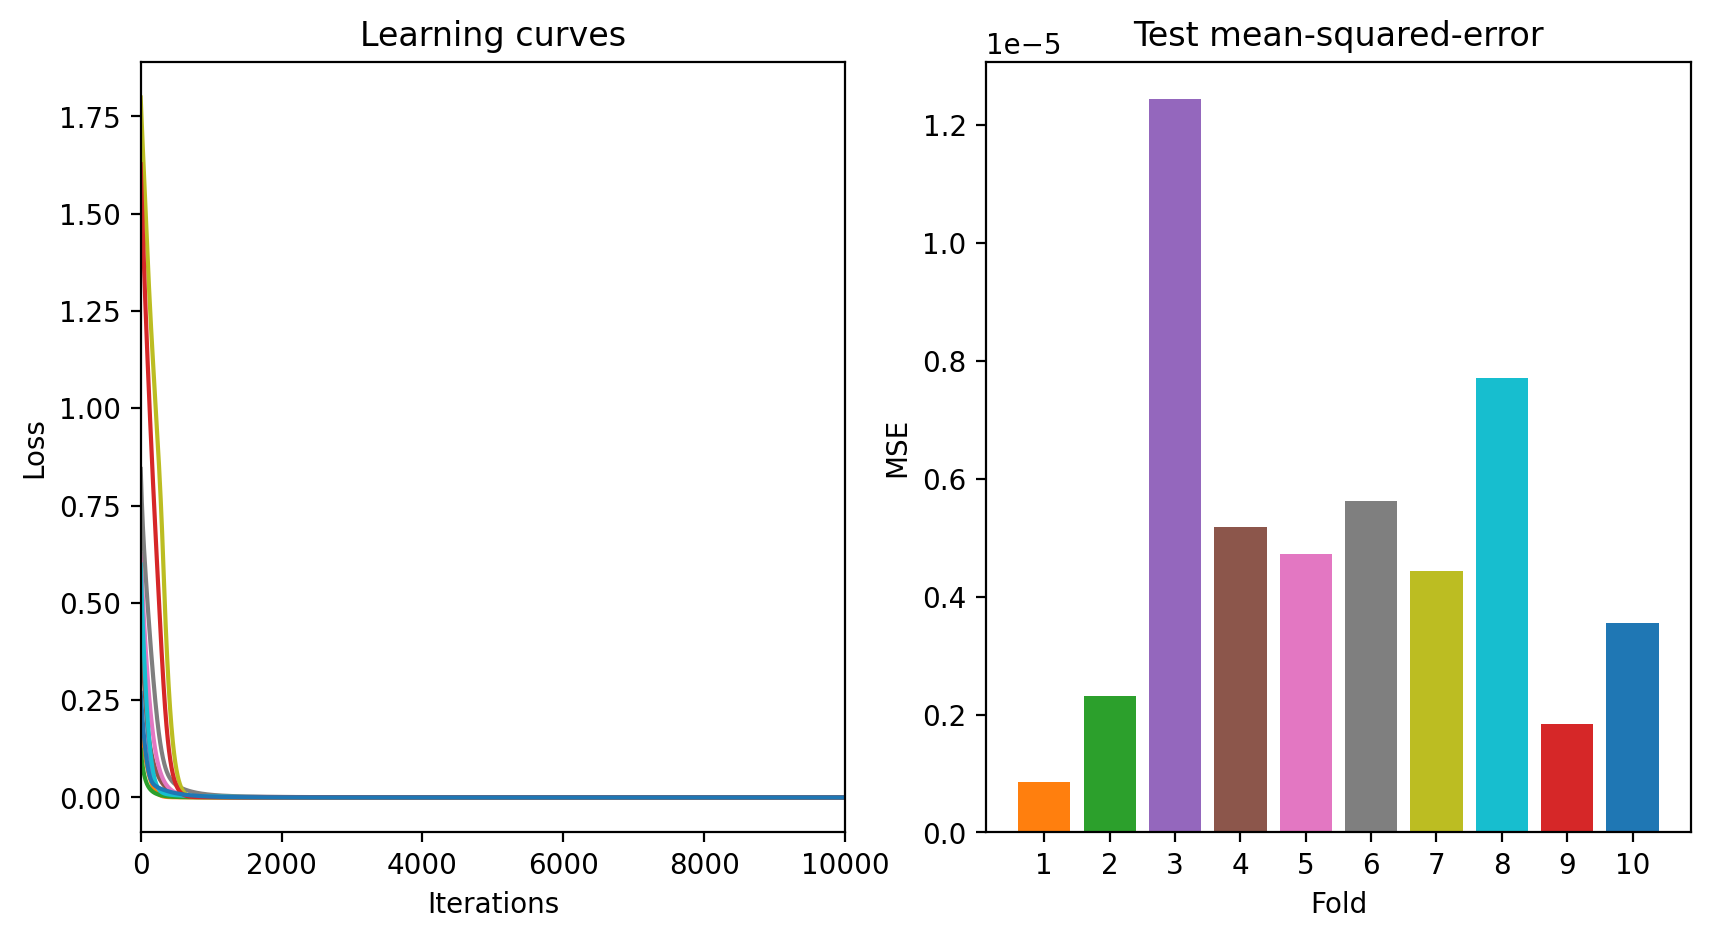

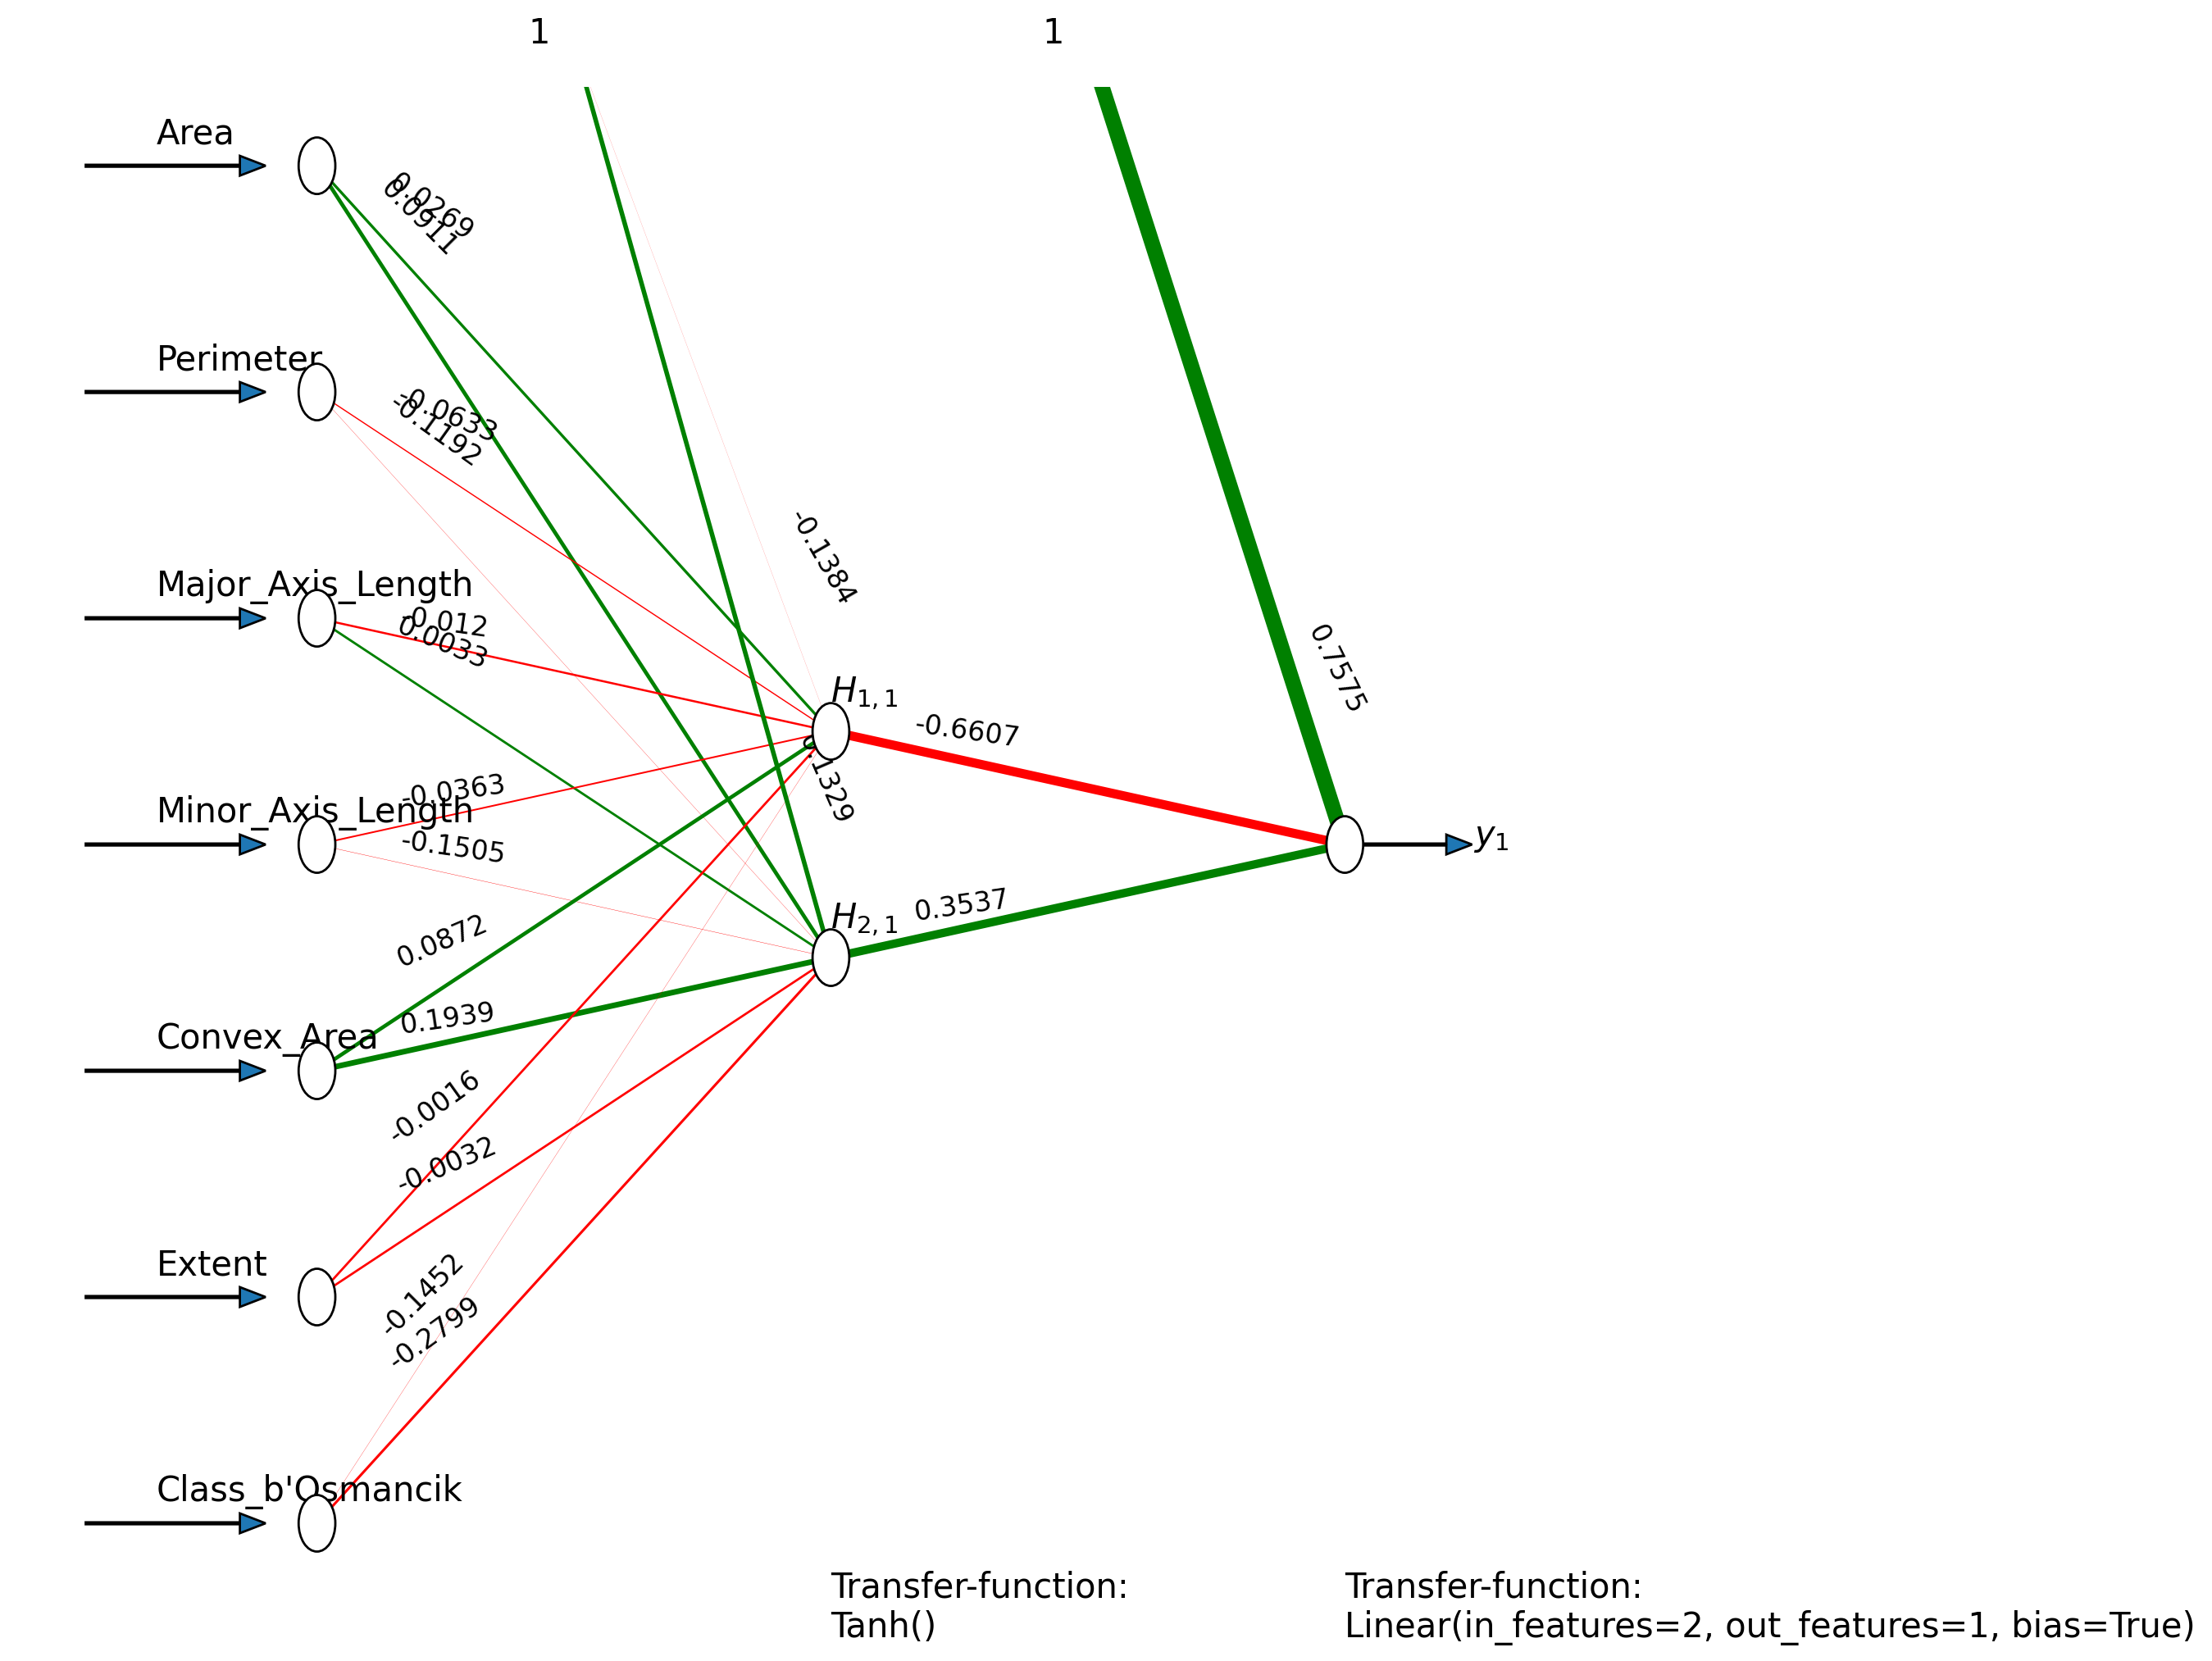


Estimated generalization error, RMSE: 0.002199999988079071


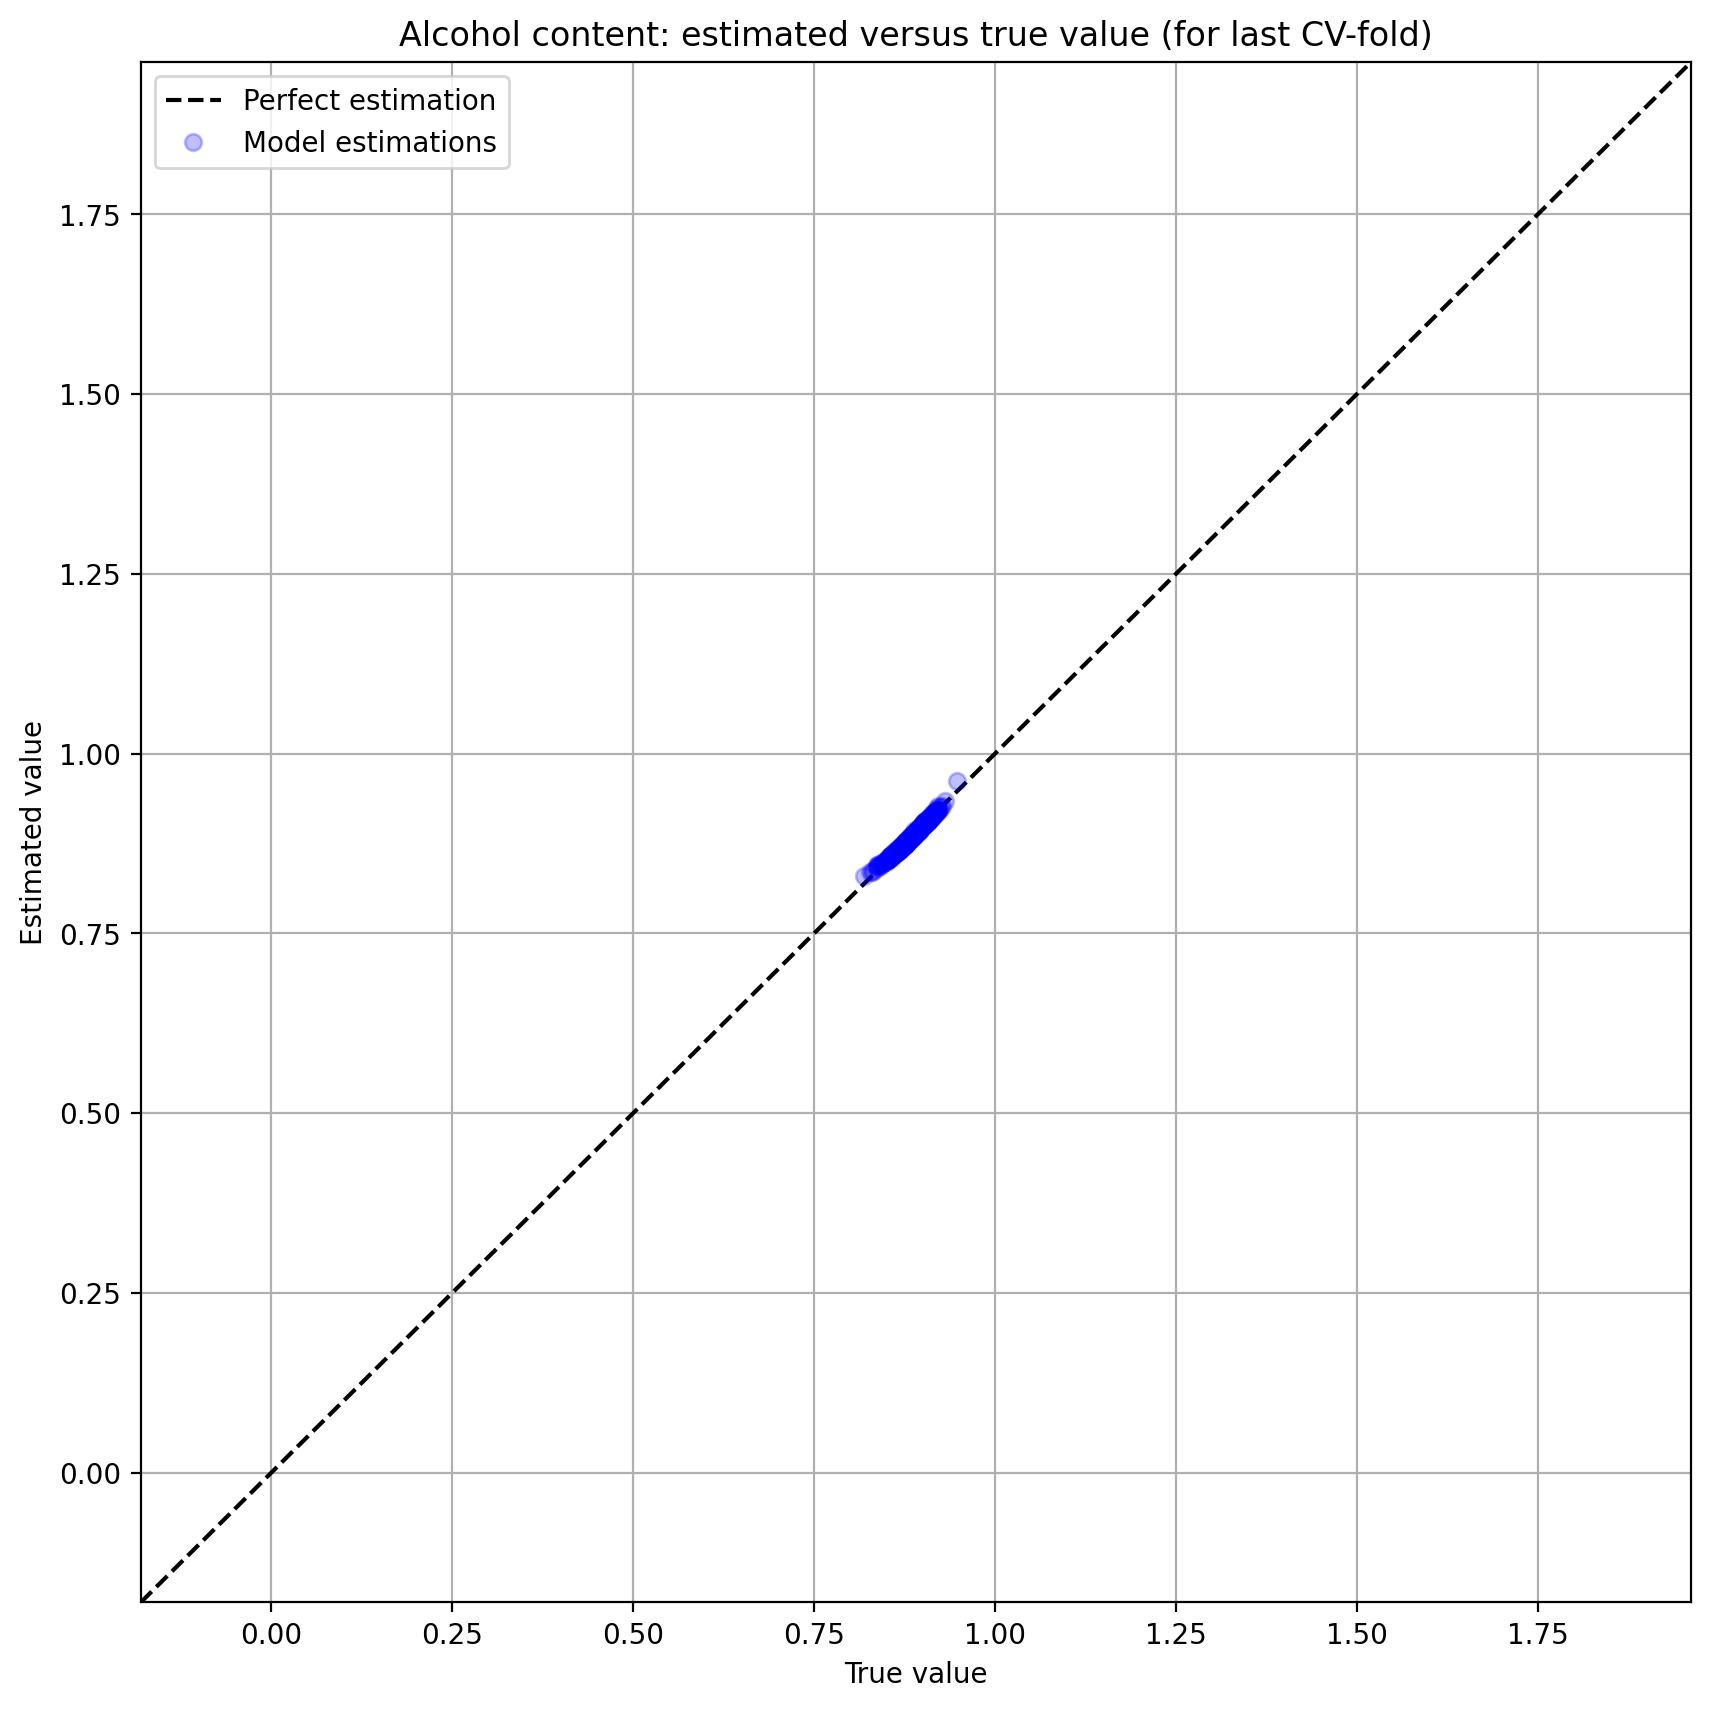

In [19]:
# Load csv data file and extract variables of interest
data = pd.read_csv(data_file)

data = pd.get_dummies(data, columns=["Class"], drop_first=True)
# transform True/False to 1/0 (categorical feature "Class_b'Osmancik")
data["Class_b'Osmancik"] = data["Class_b'Osmancik'"].astype(int)
data = data.drop(columns=["Class_b'Osmancik'"])
X = data.drop(columns=["Eccentricity"])
attributeNames = X.columns.tolist()
X=X.values
y = data["Eccentricity"]
y=y.values
 
# Load Matlab data file and extract variables of interest

N, M = X.shape


# Normalize data
X = stats.zscore(X)

## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X, 0)
    U, S, V = np.linalg.svd(Y, full_matrices=False)
    V = V.T
    # Components to be included as features
    k_pca = 3
    X = X @ V[:, :k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 2  # number of hidden units
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 10000

# K-fold crossvalidation
K = 10  # only three folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]
# Define the model
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
    torch.nn.Tanh(),  # 1st transfer function,
    torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
    # no final tranfer function, i.e. "linear output"
)
loss_fn = torch.nn.MSELoss()  # notice how this is now a mean-squared-error loss

print("Training model of type:\n\n{}\n".format(str(model())))
errors = []  # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(CV.split(X, y)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])
    y_train = torch.Tensor(y[train_index]).reshape(-1, 1)
    y_test = torch.Tensor(y[test_index]).reshape(-1, 1)

    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(
        model,
        loss_fn,
        X=X_train,
        y=y_train,
        n_replicates=n_replicates,
        max_iter=max_iter,
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_test_est = net(X_test)

    # Determine errors and errors
    se = (y_test_est.float() - y_test.float()) ** 2  # squared error
    mse = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
    errors.append(mse)  # store error rate for current CV fold

    # Display the learning curve for the best net in the current fold
    (h,) = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label("CV fold {0}".format(k + 1))
    summaries_axes[0].set_xlabel("Iterations")
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel("Loss")
    summaries_axes[0].set_title("Learning curves")

# Display the MSE across folds
summaries_axes[1].bar(
    np.arange(1, K + 1), np.squeeze(np.asarray(errors)), color=color_list
)
summaries_axes[1].set_xlabel("Fold")
summaries_axes[1].set_xticks(np.arange(1, K + 1))
summaries_axes[1].set_ylabel("MSE")
summaries_axes[1].set_title("Test mean-squared-error")

print("Diagram of best neural net in last fold:")
weights = [net[i].weight.data.numpy().T for i in [0, 2]]
biases = [net[i].bias.data.numpy() for i in [0, 2]]
tf = [str(net[i]) for i in [1, 2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print(
    "\nEstimated generalization error, RMSE: {0}".format(
        round(np.sqrt(np.mean(errors)), 4)
    )
)

# When dealing with regression outputs, a simple way of looking at the quality
# of predictions visually is by plotting the estimated value as a function of
# the true/known value - these values should all be along a straight line "y=x",
# and if the points are above the line, the model overestimates, whereas if the
# points are below the y=x line, then the model underestimates the value
plt.figure(figsize=(10, 10))
y_est = y_test_est.data.numpy()
y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true]) - 1, np.max([y_est, y_true]) + 1]
plt.plot(axis_range, axis_range, "k--")
plt.plot(y_true, y_est, "ob", alpha=0.25)
plt.legend(["Perfect estimation", "Model estimations"])
plt.title("Alcohol content: estimated versus true value (for last CV-fold)")
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.grid()

plt.show()





In [21]:
type(data)

pandas.core.frame.DataFrame

# Classification

## Task 1

The problem I have chosen to address is a binary classification task.  The 'Class' column within the dataset serves as the target variable, distinguishing between two distinct categories of rice, 'Cammeo' and 'Osmancik'. Consequently, each rice grain instance is categorized as either 'Cammeo' or 'Osmancik', establishing the binary nature of this classification challenge.

In [20]:
# Prepare the dataset
le = LabelEncoder()
data['Class_encoded'] = le.fit_transform(data['Class'])
X = data.drop(['Class', 'Class_encoded'], axis=1)
y = data['Class_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KeyError: 'Class'

## Task 2

### Logistic Regression

In [ ]:
# Preparation and definition of parameter grid for Logistic Regression
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
param_grid = {'C': [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18]}

In [ ]:
# Fit GridSearchCV to training data to find the best Logistic Regression model
grid_search = GridSearchCV(log_reg, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters:  {'C': 0.06}
Best cross-validation score: 0.93


### KNN

In [ ]:
# Preparation and definition of parameter grid for KNN
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1, 15))}

In [ ]:
# Fit GridSearchCV to training data to find the best KNN model
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters:  {'n_neighbors': 7}
Best cross-validation score: 0.88


For logistic regression, the complexity-controlling parameter λ, which is inversely related to the parameter 'C', is chosen as 50/3 (C=0.06). This value has been selected from a range: [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18]. This implies that we expect some regularization to prevent overfitting while retaining the model's capacity to capture the underlying patterns in the data.

For the KNN algorithm, the complexity is controlled by the number of neighbors, k, which has been selected as 7. This parameter was chosen from a smaller, more targeted range: [1, 15]. A k value of 7 strikes a balance, aiming to ensure that the model generalizes well to new data without being overly complex or too simplistic.

## Task 3

In [ ]:
# Setup for cross-validation
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
outer_results = []

In [ ]:
# Define the baseline error rate function
def baseline_error_rate(y_true, y_pred):
    return np.sum(y_pred != y_true) / len(y_true)

# Conduct cross-validation with grid search for Logistic Regression and KNN
for i, (train_index, test_index) in enumerate(outer_cv.split(X, y), start=1):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Logistic Regression with Grid Search
    log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
    param_grid_log_reg = {'C': [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18]}
    grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5)
    grid_search_log_reg.fit(X_train, y_train)
    
    # KNN with Grid Search
    knn = KNeighborsClassifier()
    param_grid_knn = {'n_neighbors': list(range(1, 15))}
    grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5)
    grid_search_knn.fit(X_train, y_train)
    
    # Evaluate models
    best_log_reg = grid_search_log_reg.best_estimator_
    best_log_reg.fit(X_train, y_train)
    y_pred_log_reg = best_log_reg.predict(X_test)
    
    best_knn = grid_search_knn.best_estimator_
    best_knn.fit(X_train, y_train)
    y_pred_knn = best_knn.predict(X_test)
    
    baseline_pred = np.full_like(y_test, y_train.value_counts().idxmax())
    
    # Calculate error rates
    error_rate_log_reg = baseline_error_rate(y_test, y_pred_log_reg)
    error_rate_knn = baseline_error_rate(y_test, y_pred_knn)
    error_rate_baseline = baseline_error_rate(y_test, baseline_pred)
    
    # Append results
    outer_results.append({
        'Outer fold': i,
        'Method 2': grid_search_knn.best_params_['n_neighbors'],
        'Etest_Method2': error_rate_knn * 100,
        'Logistic regression': grid_search_log_reg.best_params_['C'],
        'Etest_LogReg': error_rate_log_reg * 100,
        'Etest_Baseline': error_rate_baseline * 100
    })

results_df = pd.DataFrame(outer_results)
print(results_df)

   Outer fold  Method 2  Etest_Method2  Logistic regression  Etest_LogReg  \
0           1         3      11.286089                 0.04      6.561680   
1           2         3       8.923885                 0.04      7.349081   
2           3         3       9.448819                 0.06      6.561680   
3           4         3      11.023622                 0.04      6.561680   
4           5         3      12.073491                 0.10      8.661417   
5           6         3      12.335958                 0.08      6.824147   
6           7         3      11.023622                 0.10      7.086614   
7           8         3      12.335958                 0.12      7.611549   
8           9         3      11.811024                 0.12      7.874016   
9          10         3      12.860892                 0.18      4.986877   

   Etest_Baseline  
0       42.782152  
1       42.782152  
2       42.782152  
3       42.782152  
4       42.782152  
5       42.782152  
6       42.7

## Task 4

In [ ]:
# Perform statistical analysis
t_statistic_lr_vs_knn, p_value_lr_vs_knn = stats.ttest_rel(results_df['Etest_LogReg'], results_df['Etest_Method2'])
t_statistic_lr_vs_baseline, p_value_lr_vs_baseline = stats.ttest_rel(results_df['Etest_LogReg'], results_df['Etest_Baseline'])
t_statistic_knn_vs_baseline, p_value_knn_vs_baseline = stats.ttest_rel(results_df['Etest_Method2'], results_df['Etest_Baseline'])

In [ ]:
# Calculate confidence intervals
confidence_interval_lr_vs_knn = stats.t.interval(0.95, len(results_df['Etest_LogReg'])-1, loc=np.mean(results_df['Etest_LogReg']-results_df['Etest_Method2']), scale=stats.sem(results_df['Etest_LogReg']-results_df['Etest_Method2']))
confidence_interval_lr_vs_baseline = stats.t.interval(0.95, len(results_df['Etest_LogReg'])-1, loc=np.mean(results_df['Etest_LogReg']-results_df['Etest_Baseline']), scale=stats.sem(results_df['Etest_LogReg']-results_df['Etest_Baseline']))
confidence_interval_knn_vs_baseline = stats.t.interval(0.95, len(results_df['Etest_Method2'])-1, loc=np.mean(results_df['Etest_Method2']-results_df['Etest_Baseline']), scale=stats.sem(results_df['Etest_Method2']-results_df['Etest_Baseline']))

In [ ]:
# Print statistical analysis results
print(f"LR vs. KNN: p-value = {p_value_lr_vs_knn}, CI = {confidence_interval_lr_vs_knn}")
print(f"LR vs. Baseline: p-value = {p_value_lr_vs_baseline}, CI = {confidence_interval_lr_vs_baseline}")
print(f"KNN vs. Baseline: p-value = {p_value_knn_vs_baseline}, CI = {confidence_interval_knn_vs_baseline}")

LR vs. KNN: p-value = 1.9069615482306397e-05, CI = (-5.499180825091497, -3.1097430594229385)
LR vs. Baseline: p-value = 1.4266885777241929e-15, CI = (-36.47708199255887, -35.071474437887325)
KNN vs. Baseline: p-value = 4.759574858916058e-14, CI = (-32.38301305924021, -30.556619486691545)


### Is one model better than the other?

The p-value is approximately 0.0000197, which is approximatel less than 0.05, indicating a statistically significant improvement of the logistic regression model over the KNN. The confidence interval for the difference is also far from including 0, confirming the improvement.

### Are the two models better than the baseline?

LR vs. Baseline: The p-value is approximately 1.43e-15, which is much less than 0.05, indicating a statistically significant improvement of the logistic regression model over the baseline. The confidence interval for the difference is also far from including 0, confirming the improvement.

KNN vs. Baseline: The p-value is approximately 4.76e-14, which is much less than 0.05, indicating a statistically significant improvement of the KNN model over the baseline. The confidence interval for the difference is also far from including 0, confirming the improvement.

### Are some of the models identical?

Given the significant p-values when comparing both models to the baseline and each other, we can conclude that none of the models are identical in performance.

### What recommendations would you make based on what you’ve learned?

Selection of Model: The statistical evidence suggests that both the logistic regression and KNN models are significantly better than the baseline model, with one of them also being significantly better than the other. The specific choice between logistic regression and KNN should be based on which model had the lower error rate in the pairwise comparison, which the confidence interval suggests is the logistic regression model.

Model Deployment: Given the results, I would recommend deploying the logistic regression model for this particular dataset, as it not only outperforms the baseline but also the KNN model.

Further Analysis: Despite the statistical significance, the practical significance should also be evaluated. If the performance improvement is marginal, it may not justify the costs of changing models.

## Task 5

In [ ]:
# Train the logistic regression model using the best value of λ
for i, (train_index, test_index) in enumerate(outer_cv.split(X, y), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
    param_grid_log_reg = {'C': [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18]}
    grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5)
    grid_search_log_reg.fit(X_train, y_train)
    
    best_log_reg = grid_search_log_reg.best_estimator_
    y_pred_log_reg = best_log_reg.predict(X_test)
    
    error_rate_log_reg = baseline_error_rate(y_test, y_pred_log_reg)
    
    outer_results.append({
        'Outer fold': i,
        'Logistic regression C': grid_search_log_reg.best_params_['C'],
        'Etest_LogReg': error_rate_log_reg * 100,
    })

# Examining feature importance for Logistic Regression
feature_importance = pd.DataFrame(data={'Feature': X.columns, 'Importance': best_log_reg.coef_[0]})
print(feature_importance.sort_values(by='Importance', ascending=False))

             Feature  Importance
3  Minor_Axis_Length    0.376948
1          Perimeter    0.138839
0               Area    0.007600
6             Extent    0.003147
4       Eccentricity    0.001394
5        Convex_Area   -0.011414
2  Major_Axis_Length   -0.230331


### How Logistic Regression Makes Predictions?

It uses the sigmoid function to squeeze the output of a linear equation between 0 and 1. The model coefficients indicate the relationship between each feature and the log odds of the dependent variable, allowing the prediction of probabilities that are then mapped to class labels based on a threshold (commonly 0.5).

### Are the same features deemed relevant as for the regression part of the report?